### Currently, this notebook is used for:
    - loading the sfMixLGN experiment data in python format
    - plotting responses
    
Last update: 19.11.26  
Last access: 19.12.02

### Set up

In [87]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.cm as cm
import seaborn as sns
import helper_fcns as hf
import autoreload
import itertools
import scipy.optimize as opt
from scipy.stats import ttest_rel as paired_ttest
from scipy.stats.mstats import gmean as geomean
import LGN.sach.helper_fcns as sach_hf

import sys # so that we can import model_responses (in different folder)
import model_responses

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

%matplotlib inline 

expDir = 'LGN/';
dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/LGN/structures/';
save_loc = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/figures/reports/descrLGN_191201/';

dataList = hf.np_smart_load(dataPath + hf.get_datalist(expDir));

In [66]:
from matplotlib import rcParams
rcParams['font.size'] = 20
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

In [67]:
dir = 1;
rvcBase = 'rvcFits_191023';
rvcMod = 0;
rvcFits = hf.np_smart_load(dataPath + hf.rvc_fit_name(rvcBase, modNum=rvcMod, dir=1))
phFits = hf.np_smart_load(dataPath + hf.phase_fit_name('phaseAdvanceFits_191023', dir));

In [75]:
loss_type = 4;
loss_suff = '_loss%s' % hf.lossType_suffix(loss_type).replace('.npy', '') # for save name ONLY
DoGmodel = 2;
mod_suff = '_%s' % hf.descrMod_name(DoGmodel)[0]; # just take first character
is_joint = 1;
fLnameBase = 'descrFits_191201'
if is_joint == 1:
    fLnameBase = '%s_joint' % fLnameBase

descrFits = hf.np_smart_load(dataPath + hf.descrFit_name(loss_type, fLnameBase, hf.descrMod_name(DoGmodel)))

### Getting the stimulus conditions

To get the stimulus conditions, load each cell and "tabulate" the responses - in particular, we'll save dispersions, contrasts, and sf values for each experiment

In [70]:
nCells = len(rvcFits.keys());

allDisps = []; allCons = []; allSfs = []; allConByDisp =[]; allSfRef = [];

for cellNum in range(nCells):

    cellName = dataList['unitName'][cellNum];
    cellStruct = hf.np_smart_load(dataPath +  cellName + '_sfm.npy');
    data = cellStruct['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(dataPath, cellName)[0]
    _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(data, expInd)

    spks = hf.get_adjusted_spikerate(data, cellNum+1, expInd, dataPath, rvcBase, rvcMod, force_f1=True); #force F1, since we're in LGN
    _, _, respOrg, _ = hf.organize_resp(spks, data, expInd, respsAsRate=True);
    sfRef = respOrg[0, :, -1]; # 0 disp, highest contrast
        
    allDisps.append(stimVals[0])
    allCons.append(stimVals[1])
    allSfs.append(stimVals[2])
    allConByDisp.append(val_con_by_disp);
    # let's also save high contrast, single grating SF tuning
    allSfRef.append(sfRef);
    

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2340: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2340: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');


And now, follow through with one example, just plotting the SF tuning

In [76]:
cellNum = 13;

cellName = dataList['unitName'][cellNum-1];
cellStruct = hf.np_smart_load(dataPath +  cellName + '_sfm.npy');
data = cellStruct['sfm']['exp']['trial'];
spikes_rate = hf.get_adjusted_spikerate(data, cellNum, expInd, dataPath, rvcBase, rvcMod=rvcMod, descrFitName_f0 = None, baseline_sub=False);
_, _, respOrg, respAll = hf.organize_resp(spikes_rate, data, expInd, respsAsRate=True);

rvcCurr = rvcFits[cellNum-1][0];
descrCurr = descrFits[cellNum-1];

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2317: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [80]:
curr_inds = allConByDisp[cellNum-1][0];
curr_cons = allCons[cellNum-1][curr_inds];
conIndx = -4;
sfInds = hf.get_valid_sfs(data, 0, curr_inds[conIndx], expInd);
sfVals = allSfs[cellNum-1][sfInds];
plt_sfs = np.geomspace(sfVals[0], sfVals[-1], 100);

In [81]:
# response adjustment to avoid negative responses in fitting...
min_resp = np.nanmin(spikes_rate);
minThresh = 0.1;
# if min_resp < 0:
#     modAdj_add = - min_resp + minThresh;
# else:
#     modAdj_add = np.array(0);
modAdj_add = np.array(0)

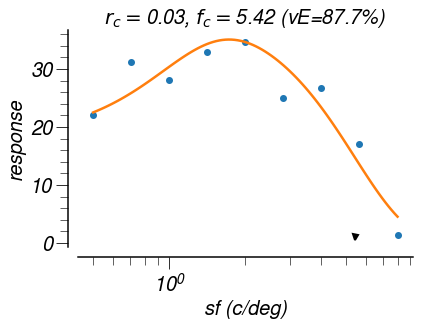

In [82]:
# gather the response at all SFS for a given contrast (i.e. sf tuning function)
sfTune = respOrg[0, :, curr_inds[conIndx]]
plt.semilogx(sfVals, sfTune, 'o');
prms = descrCurr['params'][0][curr_inds[conIndx]];
plt_dog = hf.get_descrResp(prms, plt_sfs, DoGmodel) - modAdj_add
plt.semilogx(plt_sfs, plt_dog);
f_c = hf.dog_charFreq(prms, DoGmodel)
r_c = 1/(2*np.pi*f_c);
varExpl = descrCurr
plt.title('$r_c =$%.2f, $f_c =$%.2f (vE=%.1f%%)' % (r_c, f_c, descrCurr['varExpl'][0][curr_inds[conIndx]]));
plt.semilogx(f_c, 1, 'v', color='k');
plt.xlabel('sf (c/deg)');
plt.ylabel('response');
sns.despine(offset=10)

# Response versus contrast

In [83]:
c50_ind = 2; # for rvcMod "0" (i.e. Tony)

First, load Sach's data

In [84]:
# first, let's get ready to load Sach's fits
rvcMod = 0;
rvcBase = 'rvcFits_191023'

sachPath = dataPath.replace('structures', 'sach/structures') 
sachRVC = hf.np_smart_load(sachPath + '%s%s.npy' % (rvcBase, hf.rvc_mod_suff(rvcMod)))

val_sach = sorted(sachRVC.keys())
# also create the 'allCons' etc
sach_cons = []; sach_sfs = []; sach_type = [];
sach_dl = hf.np_smart_load(sachPath + 'sachData.npy');
for v in val_sach:
    data = sach_dl[v]['data'];
    resps, stimVals, _ = sach_hf.tabulateResponses(data);

    sach_cons.append(stimVals[0]);
    sach_sfs.append(stimVals[1]);
    
    curr_type = sach_dl[v]['cellType'];
    if curr_type.startswith('P'):
        sach_type.append('parvo');
    if curr_type.startswith('M'):
        sach_type.append('magno');
    if curr_type.startswith('B'): # yes, I know that BY is a real cell type, but we're just counting this as TBD for now...
        sach_type.append('tbd');

        
sach_c50 = [[y[c50_ind] for y in sachRVC[x]['params']] for x in sorted(sachRVC.keys())]
sach_conGain = [np.array(sachRVC[x]['conGain']) for x in sorted(sachRVC.keys())]
sach_c50eff = [[hf.c50_empirical(rvcMod, x) for x in sachRVC[x]['params']] for x in sorted(sachRVC.keys())]

Then, my data

In [85]:
all_c50 = [[y[c50_ind] for y in rvcFits[x][0]['params']] if 0 in rvcFits[x] else np.nan for x in rvcFits]
all_conGain = [np.array(rvcFits[x][0]['conGain']) if 0 in rvcFits[x] else np.nan for x in sorted(rvcFits.keys())]
all_c50eff = [[hf.c50_empirical(rvcMod, x) for x in rvcFits[x][0]['params']] if 0 in rvcFits[x] else np.nan for x in sorted(rvcFits.keys())]
# flat_conGain = np.asarray(hf.flatten_list(all_conGain));

Then, combine!

In [86]:
c50s = [sach_c50, all_c50];
con_gains = [sach_conGain, all_conGain];
c50effs = [sach_c50eff, all_c50eff];
allTypes = [sach_type, dataList['unitType']];

all_metr = [c50s, con_gains, c50effs, allTypes]

for i in range(len(all_metr)):
    all_metr[i] = np.array(hf.flatten_list(all_metr[i]))
    
all_c50s, all_conGains, all_c50effs, allTypes = all_metr;

nCells = len(all_c50s);

Now, by cell type

In [14]:
c50_mean = np.nan * np.zeros((nCells, 4))
c50_min = np.nan * np.zeros((nCells, 4))
c50eff_mean = np.nan * np.zeros((nCells, 4))
c50eff_min = np.nan * np.zeros((nCells, 4))
conGain_mean = np.nan * np.zeros((nCells, 4))
conGain_max = np.nan * np.zeros((nCells, 4))

for i in range(nCells):
    curr_c50s = np.array(all_c50s[i]);
    c50_mean[i, 0] = geomean(curr_c50s[~np.isnan(curr_c50s)])
    c50_min[i, 0] = np.nanmin(all_c50s[i])

    c50eff_mean[i, 0] = np.nanmean(all_c50effs[i])
    c50eff_min[i, 0] = np.nanmin(all_c50effs[i])

    conGain_mean[i, 0] = np.nanmean(all_conGains[i])
    conGain_max[i, 0] = np.nanmax(all_conGains[i])
    
    if allTypes[i] == 'parvo':
        c50_mean[i, 1] = c50_mean[i, 0]
        c50_min[i, 1] = c50_min[i, 0]
        c50eff_mean[i, 1] = c50eff_mean[i, 0]
        c50eff_min[i, 1] = c50eff_min[i, 0]
        conGain_mean[i, 1] = conGain_mean[i, 0]
        conGain_max[i, 1] = conGain_max[i, 0]
    if allTypes[i] == 'magno':
        c50_mean[i, 2] = c50_mean[i, 0]
        c50_min[i, 2] = c50_min[i, 0]
        c50eff_mean[i, 2] = c50eff_mean[i, 0]
        c50eff_min[i, 2] = c50eff_min[i, 0]
        conGain_mean[i, 2] = conGain_mean[i, 0]
        conGain_max[i, 2] = conGain_max[i, 0]
    if allTypes[i] == 'tbd':
        c50_mean[i, 3] = c50_mean[i, 0]
        c50_min[i, 3] = c50_min[i, 0]
        c50eff_mean[i, 3] = c50eff_mean[i, 0]
        c50eff_min[i, 3] = c50eff_min[i, 0]
        conGain_mean[i, 3] = conGain_mean[i, 0]
        conGain_max[i, 3] = conGain_max[i, 0]

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/scipy/stats/stats.py:317: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: All-NaN axis encountered
  # This is added back by InteractiveShellApp.init_path()
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN axis encountered
  
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/users/plevy/.conda/envs/

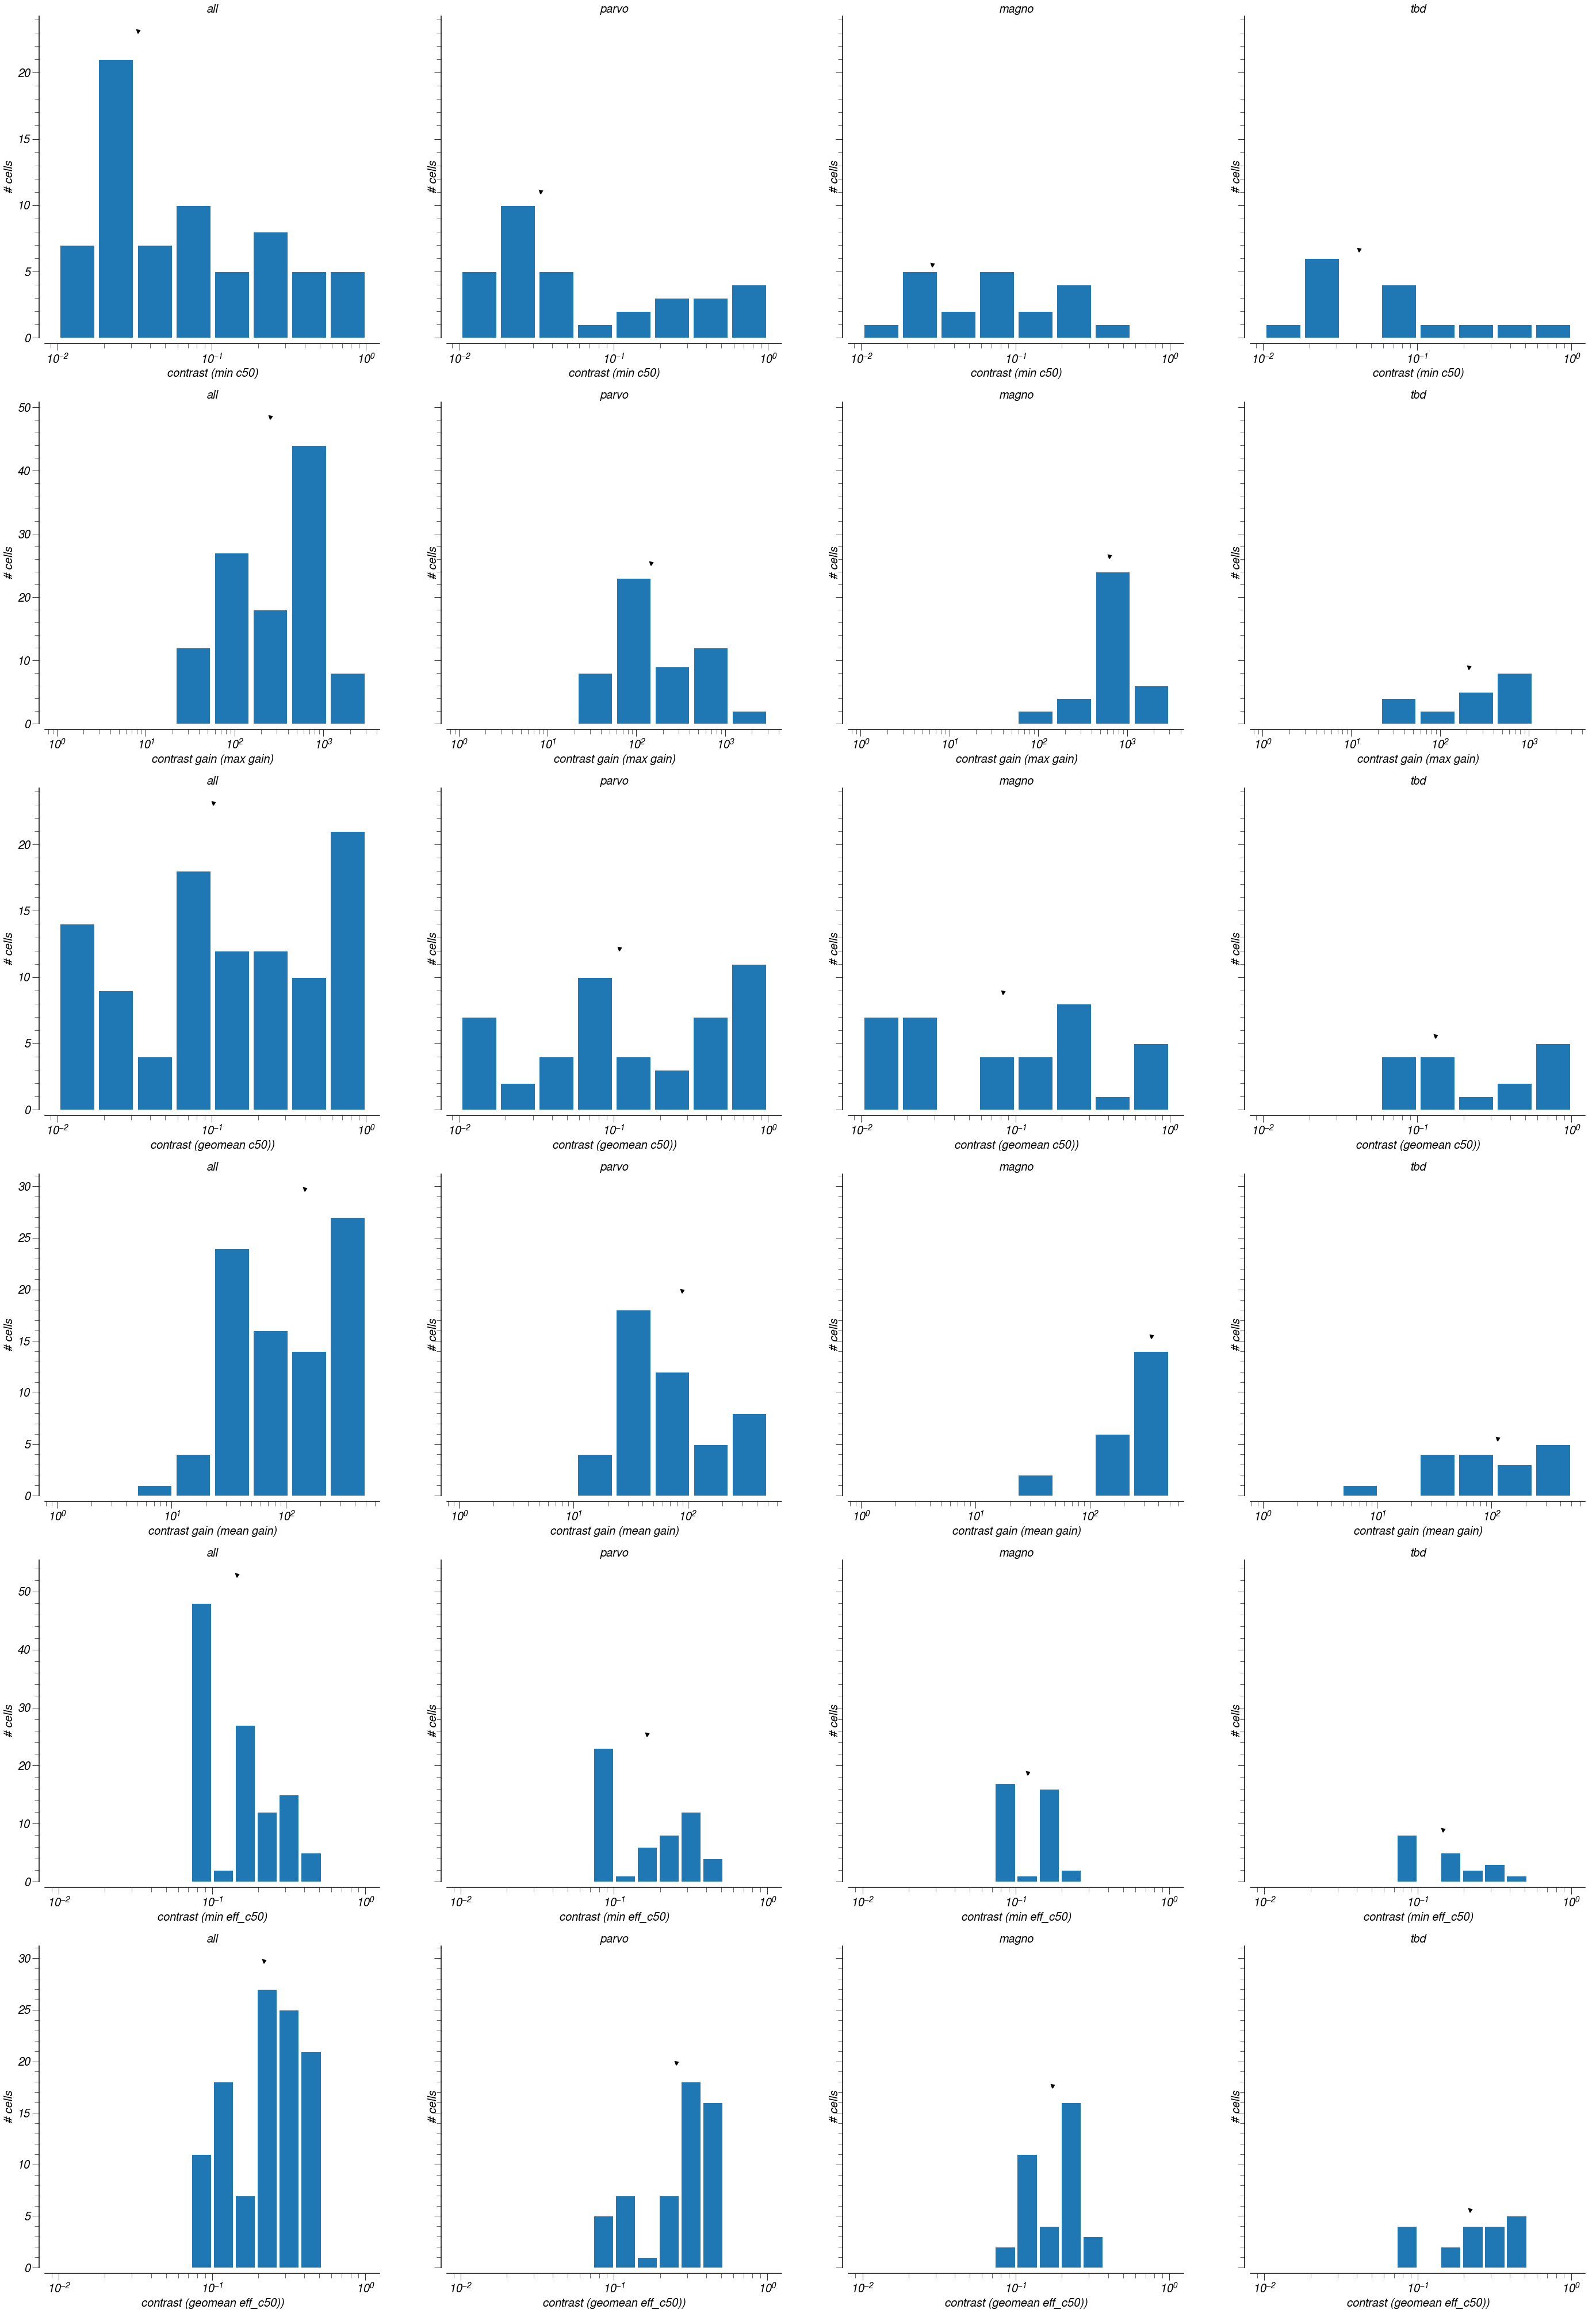

In [15]:
nrow = 6;
ncol = 4;
colStr = ['all', 'parvo', 'magno', 'tbd'];

f, ax = plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*12), sharey='row')

# first row - minimum c50
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 9)
    val_cls = np.where(~np.isnan(c50_min[:, i]))[0];
    counts, _, _ = ax[0, i].hist(c50_min[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_min[val_cls, i])
    ax[0, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[0, i].set_xscale('log')
    ax[0, i].set_title('%s' % colStr[i])
    ax[0, i].set_xlabel('contrast (min c50)')
    ax[0, i].set_ylabel('# cells')
# second row - maximum contrast gain
for i in range(ncol):
    bins = np.geomspace(1, 3e3, 9)
    val_cls = np.where(~np.isnan(conGain_max[:, i]))[0];
    counts, _, _ = ax[1, i].hist(conGain_max[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_max[val_cls, i])
    ax[1, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[1, i].set_xscale('log')
    ax[1, i].set_title('%s' % colStr[i])
    ax[1, i].set_xlabel('contrast gain (max gain)')
    ax[1, i].set_ylabel('# cells')
# third row - mean c50
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 9)
    val_cls = np.where(~np.isnan(c50_mean[:, i]))[0];
    counts, _, _ = ax[2, i].hist(c50_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_mean[val_cls, i])
    ax[2, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[2, i].set_xscale('log')
    ax[2, i].set_title('%s' % colStr[i])
    ax[2, i].set_xlabel('contrast (geomean c50))')
    ax[2, i].set_ylabel('# cells')
# fourth row - mean contrast gain
for i in range(ncol):
    bins = np.geomspace(1, 500, 9)
    val_cls = np.where(~np.isnan(conGain_mean[:, i]))[0];
    counts, _, _ = ax[3, i].hist(conGain_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_mean[val_cls, i])
    ax[3, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[3, i].set_xscale('log')
    ax[3, i].set_title('%s' % colStr[i])
    ax[3, i].set_xlabel('contrast gain (mean gain)')
    ax[3, i].set_ylabel('# cells')
# fifth row - c50 - effective (mean)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eff_min[:, i]))[0];
    counts, _, _ = ax[4, i].hist(c50eff_min[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_min[val_cls, i])
    ax[4, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[4, i].set_xscale('log')
    ax[4, i].set_title('%s' % colStr[i])
    ax[4, i].set_xlabel('contrast (min eff_c50)')
    ax[4, i].set_ylabel('# cells')
# sixth row - c50 - effective (geomean)
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 15)
    val_cls = np.where(~np.isnan(c50eff_mean[:, i]))[0];
    counts, _, _ = ax[5, i].hist(c50eff_mean[val_cls, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_mean[val_cls, i])
    ax[5, i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[5, i].set_xscale('log')
    ax[5, i].set_title('%s' % colStr[i])
    ax[5, i].set_xlabel('contrast (geomean eff_c50))')
    ax[5, i].set_ylabel('# cells')

sns.despine(offset=10)
    
saveName = "/rvcMeasures_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


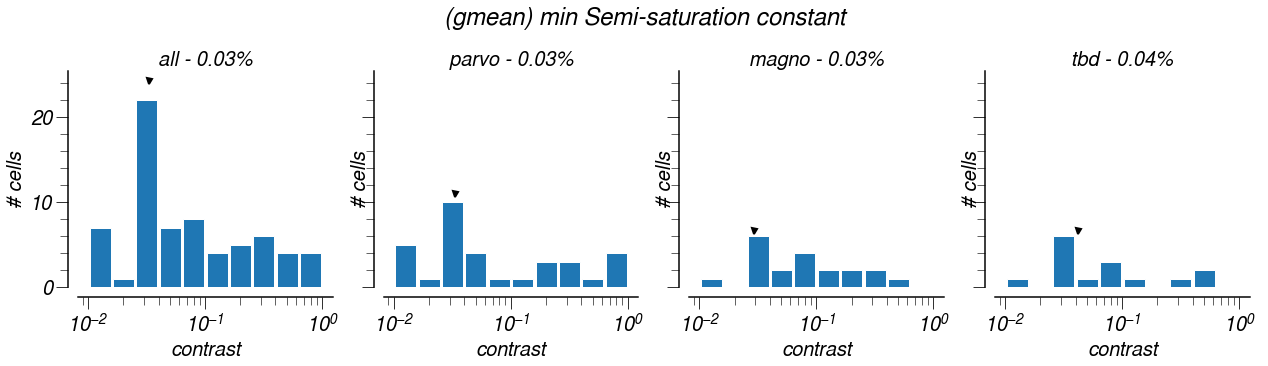

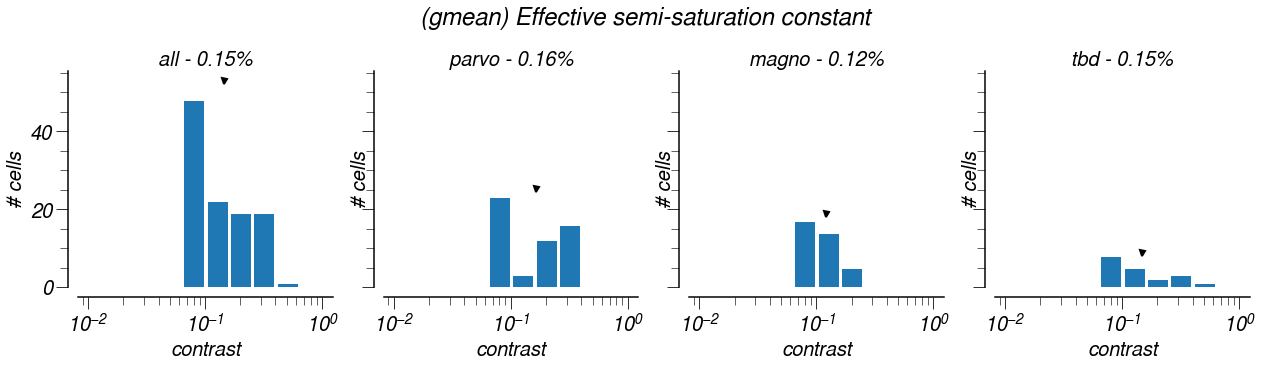

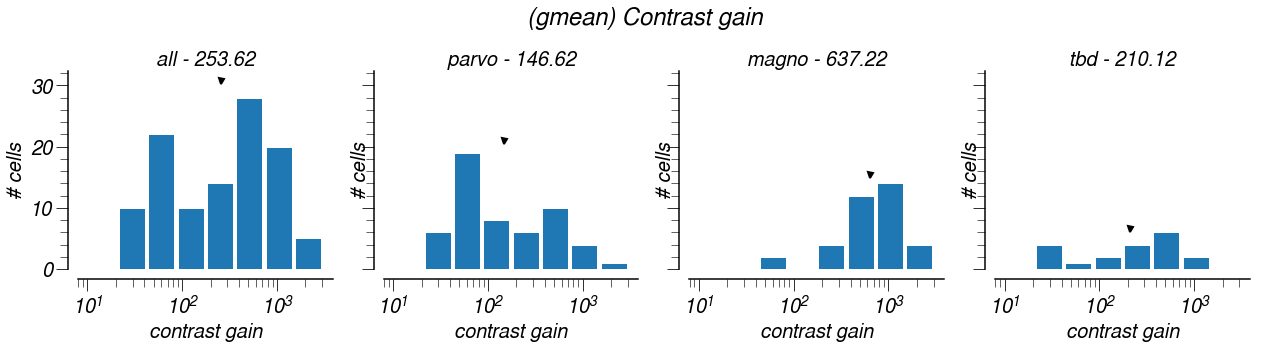

In [16]:
# first row - minimum c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50_min[:, i]))[0];
    counts, _, _ = ax[i].hist(c50_min[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50_min[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) min Semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# second row - minimum effective c50
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(0.01, 1, 11)
    val_cells = np.where(~np.isnan(c50eff_min[:, i]))[0];
    counts, _, _ = ax[i].hist(c50eff_min[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(c50eff_min[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f%%' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) Effective semi-saturation constant');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.2);

sns.despine(offset=10)

saveName = "/c50eff_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# third row - maximum contrast gain
f, ax = plt.subplots(1, 4, figsize=(21, 5), sharey='row')
for i in range(ncol):
    bins = np.geomspace(10, 3e3, 9)
    val_cells = np.where(~np.isnan(conGain_max[:, i]))[0];
    counts, _, _ = ax[i].hist(conGain_max[val_cells, i], bins, rwidth=0.9)
    ratio_gmean = geomean(conGain_max[val_cells, i])
    ax[i].plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
    ax[i].set_xscale('log')
    ax[i].set_title('%s - %.2f' % (colStr[i], ratio_gmean))
    ax[i].set_xlabel('contrast gain')
    ax[i].set_ylabel('# cells')
f.suptitle('(gmean) Contrast gain');
f.subplots_adjust(wspace=0.2, hspace=0.25, top=0.8, bottom=0.25);

sns.despine(offset=10)

saveName = "/conGain_byType%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## Difference of gaussian fits

First, analyze how much variance is explained by each model fit. This analysis is described in Cavanaugh-Heeger-Movshon (1997), and is as follows: $\%variance = 100 * [1-d(m, \overline{r})/d(\overline{r}, \overline{\overline{r}})]$, with $m :=$ model prediction, $\overline{r} :=$ mean response (per condition), and $\overline{\overline{r}} :=$ mean response over all conditions.

Futher, $d(x, y) := \dfrac{1}{N} \Sigma_s{(x_s - y_x)^2}$, where $s :=$ each condition, and $N :=$ the number of conditions.

This analysis has been moved to helper_fcns, and is attached now to the params/NLL in the descrFits structure/analysis

Let's gather some basic properties of the descriptive gaussian fits

In [111]:
hf.descrFit_name(loss_type, sach_fLnameBase, hf.descrMod_name(DoGmodel))

'descrFits_s191023_sach_tony.npy'

In [112]:
import LGN.sach.helper_fcns as sach_hf
# first, let's get ready to load Sach's fits
loss_type = 4;
DoGmodel = 2;
is_joint = 0;
sach_fLnameBase = 'descrFits_s191023'
# sach_fLnameBase = 'descrFits_s191201'
if is_joint == 1:
    sach_fLnameBase = '%s_joint' % sach_fLnameBase

sachPath = dataPath.replace('structures', 'sach/structures') 
sachFits = hf.np_smart_load(sachPath + hf.descrFit_name(loss_type, sach_fLnameBase, hf.descrMod_name(DoGmodel)))

val_sach = sorted(sachFits.keys())
# also create the 'allCons' etc
sach_cons = []; sach_sfs = []; sach_type = [];
sach_dl = hf.np_smart_load(sachPath + 'sachData.npy');
for v in val_sach:
    data = sach_dl[v]['data'];
    resps, stimVals, _ = sach_hf.tabulateResponses(data);

    sach_cons.append(stimVals[0]);
    sach_sfs.append(stimVals[1]);
    
    curr_type = sach_dl[v]['cellType'];
    if curr_type.startswith('P'):
        sach_type.append('parvo');
    if curr_type.startswith('M'):
        sach_type.append('magno');
    if curr_type.startswith('B'): # yes, I know that BY is a real cell type, but we're just counting this as TBD for now...
        sach_type.append('tbd');


In [113]:
# first, load my fits
val_cells = sorted(descrFits.keys())

all_params = [descrFits[x]['params'][0] for x in val_cells]
flat_params = np.asarray(hf.flatten_list(all_params))
all_varExpl = [descrFits[x]['varExpl'][0] for x in val_cells]
flat_varExpl = np.asarray(hf.flatten_list(all_varExpl));
all_prefSf = [descrFits[x]['prefSf'][0] for x in val_cells]
flat_prefSf = np.asarray(hf.flatten_list(all_varExpl));
all_NLL = [descrFits[x]['NLL'][0] for x in val_cells]
flat_NLL = np.asarray(hf.flatten_list(all_NLL));
all_cfreq = [np.asarray([hf.dog_charFreq(x, DoGmodel) for x in y]) for y in all_params]
flat_cfreq = np.asarray(hf.flatten_list(all_cfreq));

# then, sach's fits

allS_params = [sachFits[x]['params'] for x in val_sach]
flatS_params = np.asarray(hf.flatten_list(allS_params))
allS_varExpl = [sachFits[x]['varExpl'] for x in val_sach]
flatS_varExpl = np.asarray(hf.flatten_list(allS_varExpl));
allS_prefSf = [[hf.dog_prefSf(x, DoGmodel) for x in y] for y in allS_params]
flatS_prefSf = np.asarray(hf.flatten_list(allS_varExpl));
allS_NLL = [sachFits[x]['NLL'] for x in val_sach]
flatS_NLL = np.asarray(hf.flatten_list(allS_NLL));
allS_cfreq = [np.asarray([hf.dog_charFreq(x, DoGmodel) for x in y]) for y in allS_params]
flatS_cfreq = np.asarray(hf.flatten_list(allS_cfreq));

# n_cells = len(all_params);
# n_cons = np.array([len(allConByDisp[x][0]) for x in val_cells])
# max_nCons = np.max(n_cons)

In [114]:
### NOTE: Sach uses 70% as his varExpl cut-off
thresh_varExpl = 70; # i.e. what is the threshold for variance explained for counting that fit/params in the analysis?
valid_inds = np.where(flat_varExpl > thresh_varExpl)[0]

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Now, gather the indices for all valid (i.e. supra-variance-explained-threshold) conditions

In [115]:
prms = [flat_params, flatS_params];
all_keys = [val_cells, val_sach];
all_types = [dataList['unitType'], sach_type]
all_flatVE = [flat_varExpl, flatS_varExpl]
expNum = [np.zeros(len(val_cells, )), np.ones(len(val_sach, ))]
### first, some metadata
# FOR SINGLE GRATINGS, get the indices into the list of all cons/params/etc
single_myData = [np.array(x[0]) for x in allConByDisp];
single_sachData = [np.arange(len(x)) for x in sach_cons]
con_inds = [single_myData, single_sachData]
# and the actualy contrat values
cons_myData = [allCons[x][y] for x,y in zip(val_cells, single_myData)]
con_vals = [cons_myData, sach_cons]

all_gainC = []; all_gainS = []; all_gainRat = [];
all_radC = []; all_radS = []; all_radRat = [];
# and for contrast
allConVals = []; allConInds = [];

# now, we try to merge everything!
for fp, vi in zip(prms, all_keys):

    gain_c = [hf.dog_get_param(x, DoGmodel, 'gc') for x in fp[vi]]
    all_gainC.append(gain_c);
    gain_s = [hf.dog_get_param(x, DoGmodel, 'gs') for x in fp[vi]]
    all_gainS.append(gain_s);
    
    gain_ratio = np.divide(gain_c, gain_s);
    all_gainRat.append(gain_ratio);
    
    # radius
    rad_c = [hf.dog_get_param(x, DoGmodel, 'rc') for x in fp[vi]]
    all_radC.append(rad_c);
    rad_s = [hf.dog_get_param(x, DoGmodel, 'rs') for x in fp[vi]]
    all_radS.append(rad_s);

    rad_ratio = np.divide(rad_c, rad_s);
    all_radRat.append(rad_ratio);
    
### pack to easily flatten and cast as array
# more to flatten:
all_prms = [all_params, allS_params];
all_vE = [all_varExpl, allS_varExpl];
all_psf = [all_prefSf, allS_prefSf];
all_cf  = [all_cfreq, allS_cfreq];
# now, flatten!
all_dogs = [all_gainC, all_gainS, all_gainRat, all_radC, all_radS, all_radRat, all_keys, con_inds, con_vals, all_prms, all_vE, all_psf, all_types, all_cf, expNum, all_flatVE];
for dog in range(len(all_dogs)):
    all_dogs[dog] = np.array(hf.flatten_list(all_dogs[dog]))
# finally, unpack for use
all_gainC, all_gainS, all_gainRat, all_radC, all_radS, all_radRat, all_keys, all_cInds, all_cVals, all_params, all_varExpl, all_prefSf, all_types, all_cfreq, expNum, all_flatVE = all_dogs;


n_cells = len(all_gainC)
max_nCons = np.max([len(x) for x in all_cInds])

In [118]:
''' To be used if analyzing all parameter values (i.e. not flattened/subsetted)
# gain
gain_c = [[x[ind_gain_c] for x in c] for c in all_params]
gain_s = [[x[ind_gain_s] for x in c] for c in all_params]

gain_ratio = np.divide(gain_c, gain_s);
gain_ratio = gain_ratio[~np.isnan(gain_ratio)]

# frequency
freq_c = [[x[ind_freq_c] for x in c] for c in all_params]
freq_s = [[x[ind_freq_s] for x in c] for c in all_params]

freq_ratio = np.divide(freq_c, freq_s);
freq_ratio = freq_ratio[~np.isnan(freq_ratio)]
'''

' To be used if analyzing all parameter values (i.e. not flattened/subsetted)\n# gain\ngain_c = [[x[ind_gain_c] for x in c] for c in all_params]\ngain_s = [[x[ind_gain_s] for x in c] for c in all_params]\n\ngain_ratio = np.divide(gain_c, gain_s);\ngain_ratio = gain_ratio[~np.isnan(gain_ratio)]\n\n# frequency\nfreq_c = [[x[ind_freq_c] for x in c] for c in all_params]\nfreq_s = [[x[ind_freq_s] for x in c] for c in all_params]\n\nfreq_ratio = np.divide(freq_c, freq_s);\nfreq_ratio = freq_ratio[~np.isnan(freq_ratio)]\n'

In [119]:
print('Of %d gain ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(all_gainRat), 100*sum(all_gainRat>1)/len(all_gainRat)))
print('Of %d radius ratios, %.1f%% are less than 1 (i.e. c < s)\n' % (len(all_radRat), 100*sum(all_radRat<1)/len(all_radRat)))

Of 111 gain ratios, 83.8% are greater than 1 (i.e. c > s)

Of 111 radius ratios, 77.5% are less than 1 (i.e. c < s)



/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Now, let's plot the trajectory of each parameter (and peak SF) with contrast, as split by cell

In [120]:
all_rc = np.nan * np.zeros((n_cells, max_nCons));
all_rs = np.nan * np.zeros((n_cells, max_nCons));
all_gc = np.nan * np.zeros((n_cells, max_nCons));
all_gs = np.nan * np.zeros((n_cells, max_nCons));
all_psf = np.nan * np.zeros((n_cells, max_nCons));
all_cfr = np.nan * np.zeros((n_cells, max_nCons));
all_volc = np.nan * np.zeros((n_cells, max_nCons));
all_vols = np.nan * np.zeros((n_cells, max_nCons));
all_volrat = np.nan * np.zeros((n_cells, max_nCons));

# and make space for normalized values of the same, where we normalize to the parameter value at the highest valid contrast
all_rc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_rs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_psf_norm = np.nan * np.zeros((n_cells, max_nCons));
all_cfr_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_vols_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volrat_norm = np.nan * np.zeros((n_cells, max_nCons));

# and contrast ratios...
all_rc_conRat = np.nan * np.zeros((n_cells, ))
all_rs_conRat = np.nan * np.zeros((n_cells, ))
all_volc_conRat = np.nan * np.zeros((n_cells, ))
all_vols_conRat = np.nan * np.zeros((n_cells, ))

In [121]:
# here, organize and compute everything we need
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    
    # take into account that not all cells are in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]   
#     ii = val_cells[i]
#     cons_curr = allConByDisp[ii][0];
#     con_inds = range(len(cons_curr));
    # messy list comprehension, but basically only get the parameter if that fit meets the variance explained thresh
    all_rc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_rs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_psf[i, con_inds] = [all_prefSf[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_cfr[i, con_inds] = [all_cfreq[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    # now compute volumes, ratio of volumes
    all_volc[i, con_inds] = np.multiply(all_gc[i, con_inds], np.square(all_rc[i, con_inds]))
    all_vols[i, con_inds] = np.multiply(all_gs[i, con_inds], np.square(all_rs[i, con_inds]))
    all_volrat[i, con_inds] = np.divide(all_vols[i, con_inds], all_volc[i, con_inds])
    
    if np.all(np.isnan(all_rc[i, :])): # don't normalize if they're all NaN
        continue;
    highest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][-1];
    lowest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][0];
    all_rc_norm[i, con_inds] = np.divide(all_rc[i, con_inds], all_rc[i, highest_valIndex]);
    all_rs_norm[i, con_inds] = np.divide(all_rs[i, con_inds], all_rs[i, highest_valIndex]);
    all_gc_norm[i, con_inds] = np.divide(all_gc[i, con_inds], all_gc[i, highest_valIndex]);
    all_gs_norm[i, con_inds] = np.divide(all_gs[i, con_inds], all_gs[i, highest_valIndex]);
    all_psf_norm[i, con_inds] = np.divide(all_psf[i, con_inds], all_psf[i, highest_valIndex]) 
    all_cfr_norm[i, con_inds] = np.divide(all_cfr[i, con_inds], all_cfr[i, highest_valIndex]) 
    # now compute volumes, ratio of volumes
    all_volc_norm[i, con_inds] = np.divide(all_volc[i, con_inds], all_volc[i, highest_valIndex])
    all_vols_norm[i, con_inds] = np.divide(all_vols[i, con_inds], all_vols[i, highest_valIndex])
    all_volrat_norm[i, con_inds] = np.divide(all_volrat[i, con_inds], all_volrat[i, highest_valIndex])

    # measure ratio of center, surround radii at highest/lowest contrast; same for volumes
    all_rc_conRat[i] = all_rc[i, highest_valIndex]/all_rc[i, lowest_valIndex];
    all_rs_conRat[i] = all_rs[i, highest_valIndex]/all_rs[i, lowest_valIndex];
    all_volc_conRat[i] = all_volc[i, highest_valIndex]/all_volc[i, lowest_valIndex];
    all_vols_conRat[i] = all_vols[i, highest_valIndex]/all_vols[i, lowest_valIndex];

#### Parameter trends versus contrast

In [99]:
from scipy.stats import binned_statistic

In [100]:
onlyValidgc = [all_gc[x, range(len(all_cInds[x]))] for x in range(n_cells)]

In [101]:
binned_statistic(all_cVals, onlyValidgc, statistic='mean')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


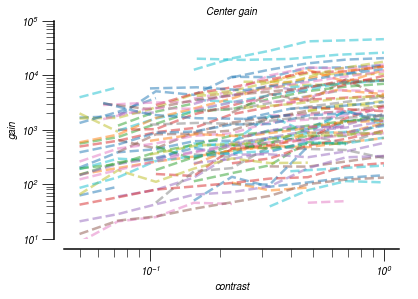

In [102]:
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc[i, con_inds], '--', alpha=0.5)
    
    #     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_gc[i, :], '--', alpha=0.5)
# gc_medians = np.nanmedian(all_gc, 0);
# plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([1e1, 1e5])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range
sns.despine(offset=10)

In [129]:
# cN = 58;
# print('gains: \nc:%s\ns:%s' % (all_gc[cN-1, :], all_gs[cN-1, :]))
# print('rads: \nc:%s\ns:%s' % (all_rc[cN-1, :], all_rs[cN-1, :]))
# print('vols: \nc:%s\ns:%s' % (all_volc[cN-1, :], all_vols[cN-1, :]))


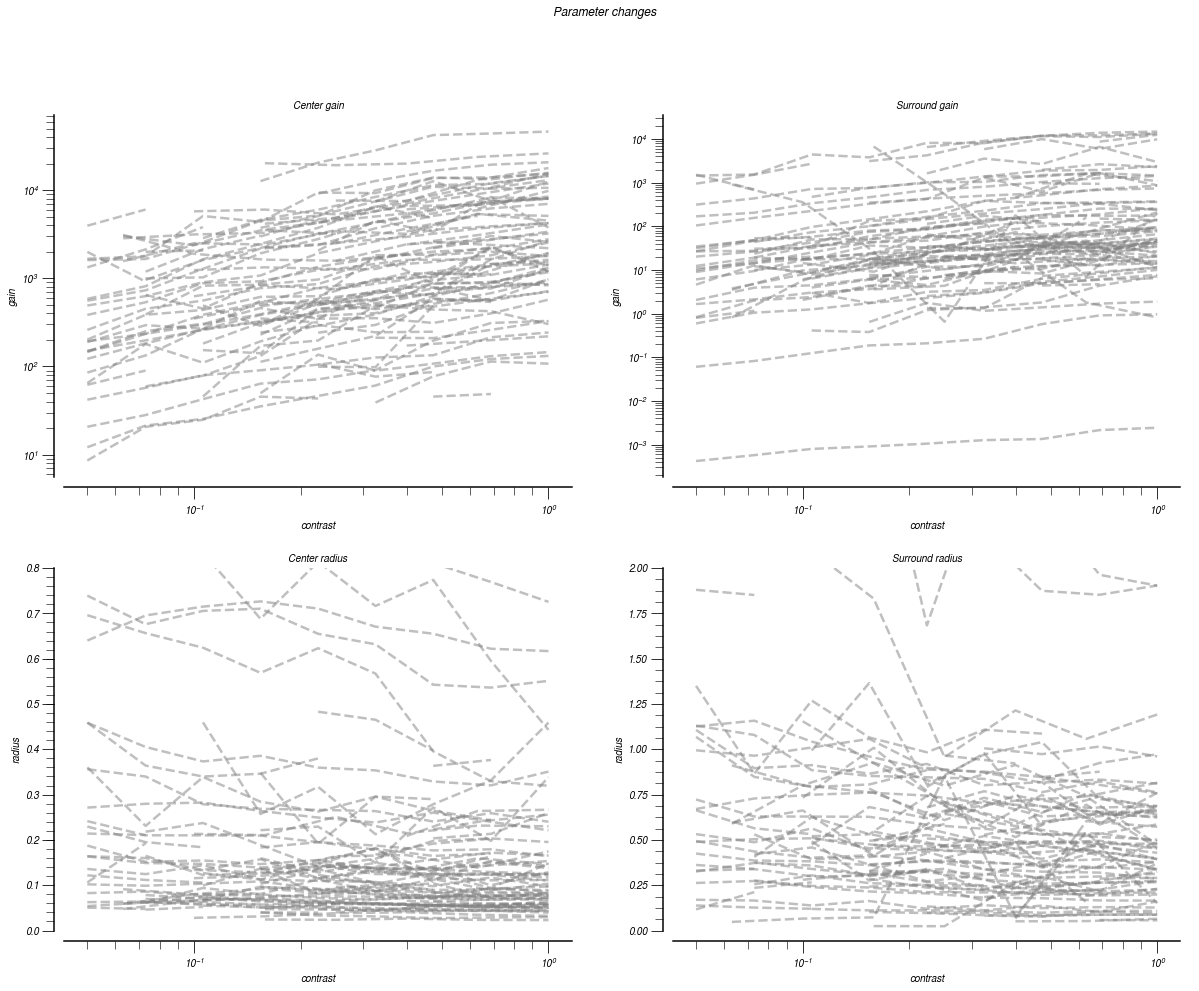

In [130]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5) # mean gray

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc[i, con_inds], '--', color=gray, alpha=0.5)

#     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_gc[i, :], '--', color=gray, alpha=0.5)
# gc_medians = np.nanmedian(all_gc, 0);
# plt.plot(val_cons, gc_medians, 'r', linewidth=3)
# plt.ylim([0, 75])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gs[i, con_inds], '--', color=gray, alpha=0.5)    

    #     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_gs[i, :], '--', color=gray, alpha=0.5)
# gs_medians = np.nanmedian(all_gs, 0);
# plt.plot(val_cons, gs_medians, 'r', linewidth=3)
# plt.ylim([10e0, 10e4])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Surround gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc[i, con_inds], '--', color=gray, alpha=0.5)
    
#     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_rc[i, :], '--', color=gray, alpha=0.5)
# rc_medians = np.nanmedian(all_rc, 0);
# plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.8]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    # now, get the valid contrast indices...
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs[i, con_inds], '--', color=gray, alpha=0.5)
    
#     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     val_cons = allCons[ii][con_inds]
#     plt.plot(val_cons, all_rs[i, :], '--', color=gray, alpha=0.5)
# rs_medians = np.nanmedian(all_rs, 0);
# plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/DoG_params%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

The center (and, to a lesser extent, the surround) gain increases steadily with contrast. The center and surround radii seem relatively constant. These findings, though, are obscured by the different cells which contribute to each of the median values - i.e. cells 1, 3, 5 might contribute to lowest contrast, and 2, 4, 5 to the highest -- they each have their own range of values, so a "raw" median/trend might be misleading.

#### Normalized trends

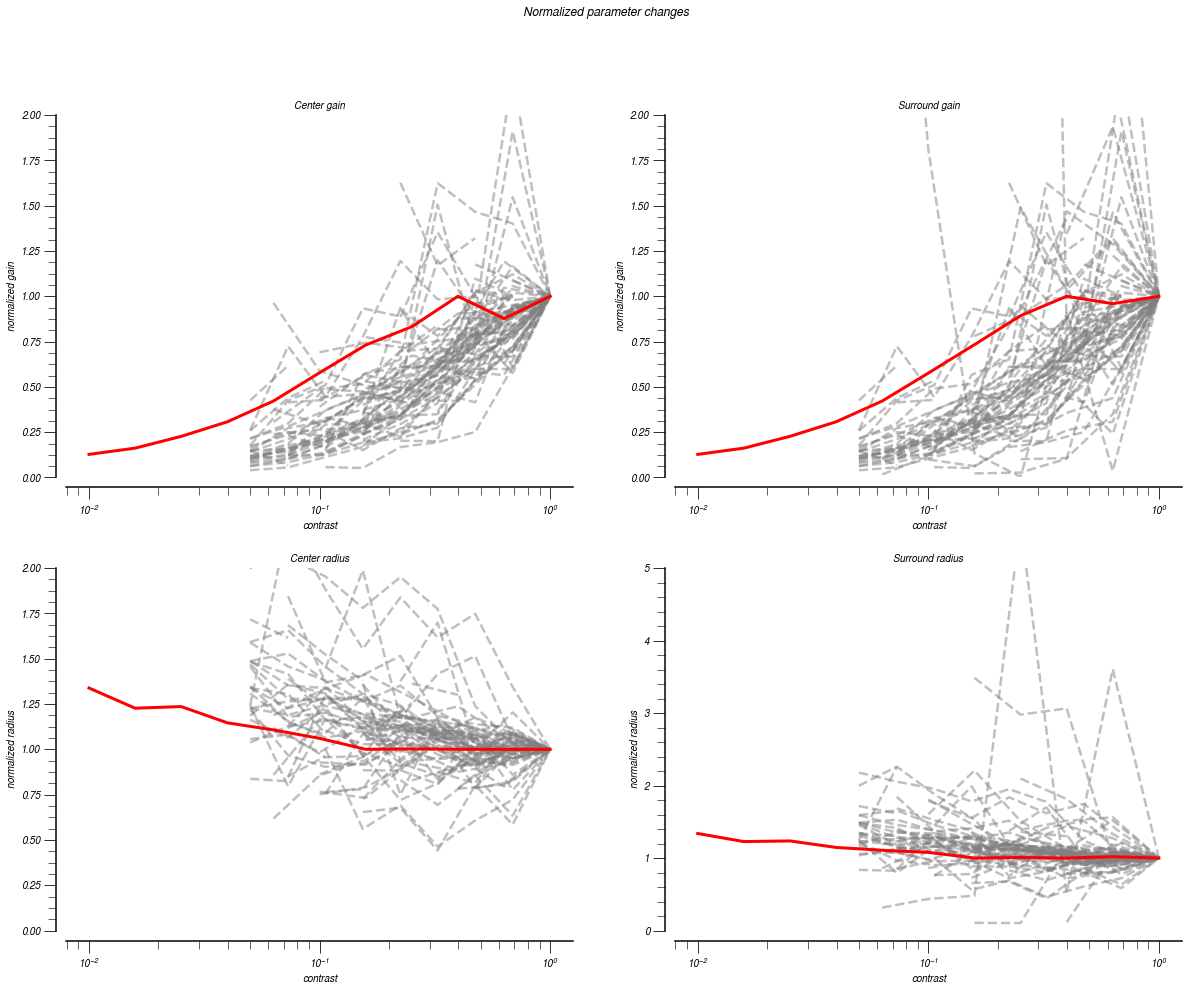

In [131]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5)

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gc_norm[i, con_inds], '--', c=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc_norm, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Center gain')
plt.xscale('log')

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_gs_norm[i, con_inds], '--', c=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs_norm, 0);
plt.plot(val_cons, gs_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Surround gain')
plt.xscale('log')

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc_norm[i, con_inds], '--', c=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Center radius')
plt.xscale('log')

# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs_norm[i, con_inds], '--', c=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Normalized parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/DoG_params_norm%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Now, a more clear picture emerges: gain increases with contrast, and radius - both center and surround - decrease with contrast. This is what Sach finds (plots/reports only on the radius change).

### Reproduce Sach's figure 3-3

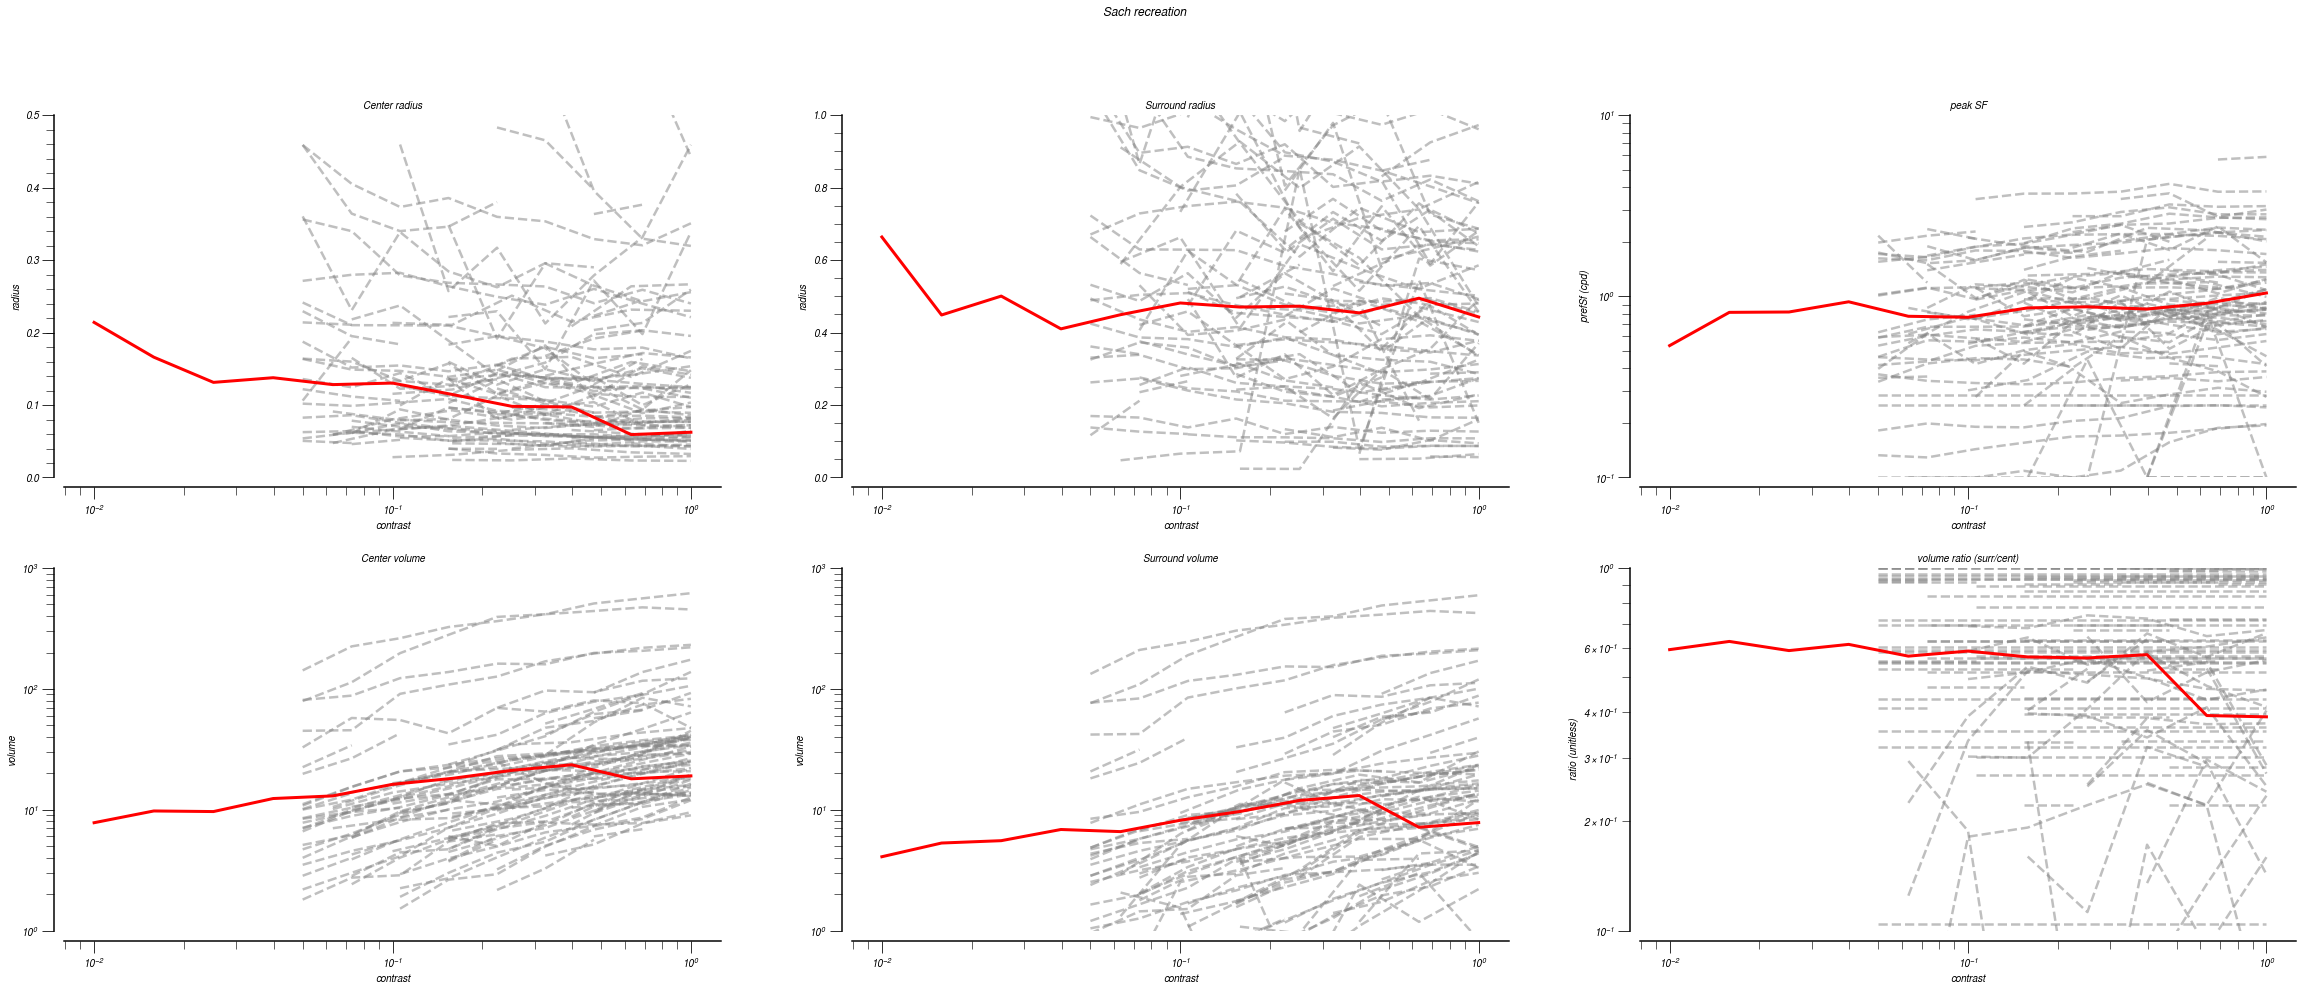

In [132]:
f, ax = plt.subplots(2, 3, figsize=(40, 15))

gray = cm.gray(0.5) # mean gray

# center radius
plt.subplot(2, 3, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc[i, con_inds], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 3, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs[i, con_inds], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 1]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_psf[i, con_inds], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volc[i, con_inds], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e0, 1e3]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_vols[i, con_inds], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e0, 1e3]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volrat[i, con_inds], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e0]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/sach%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


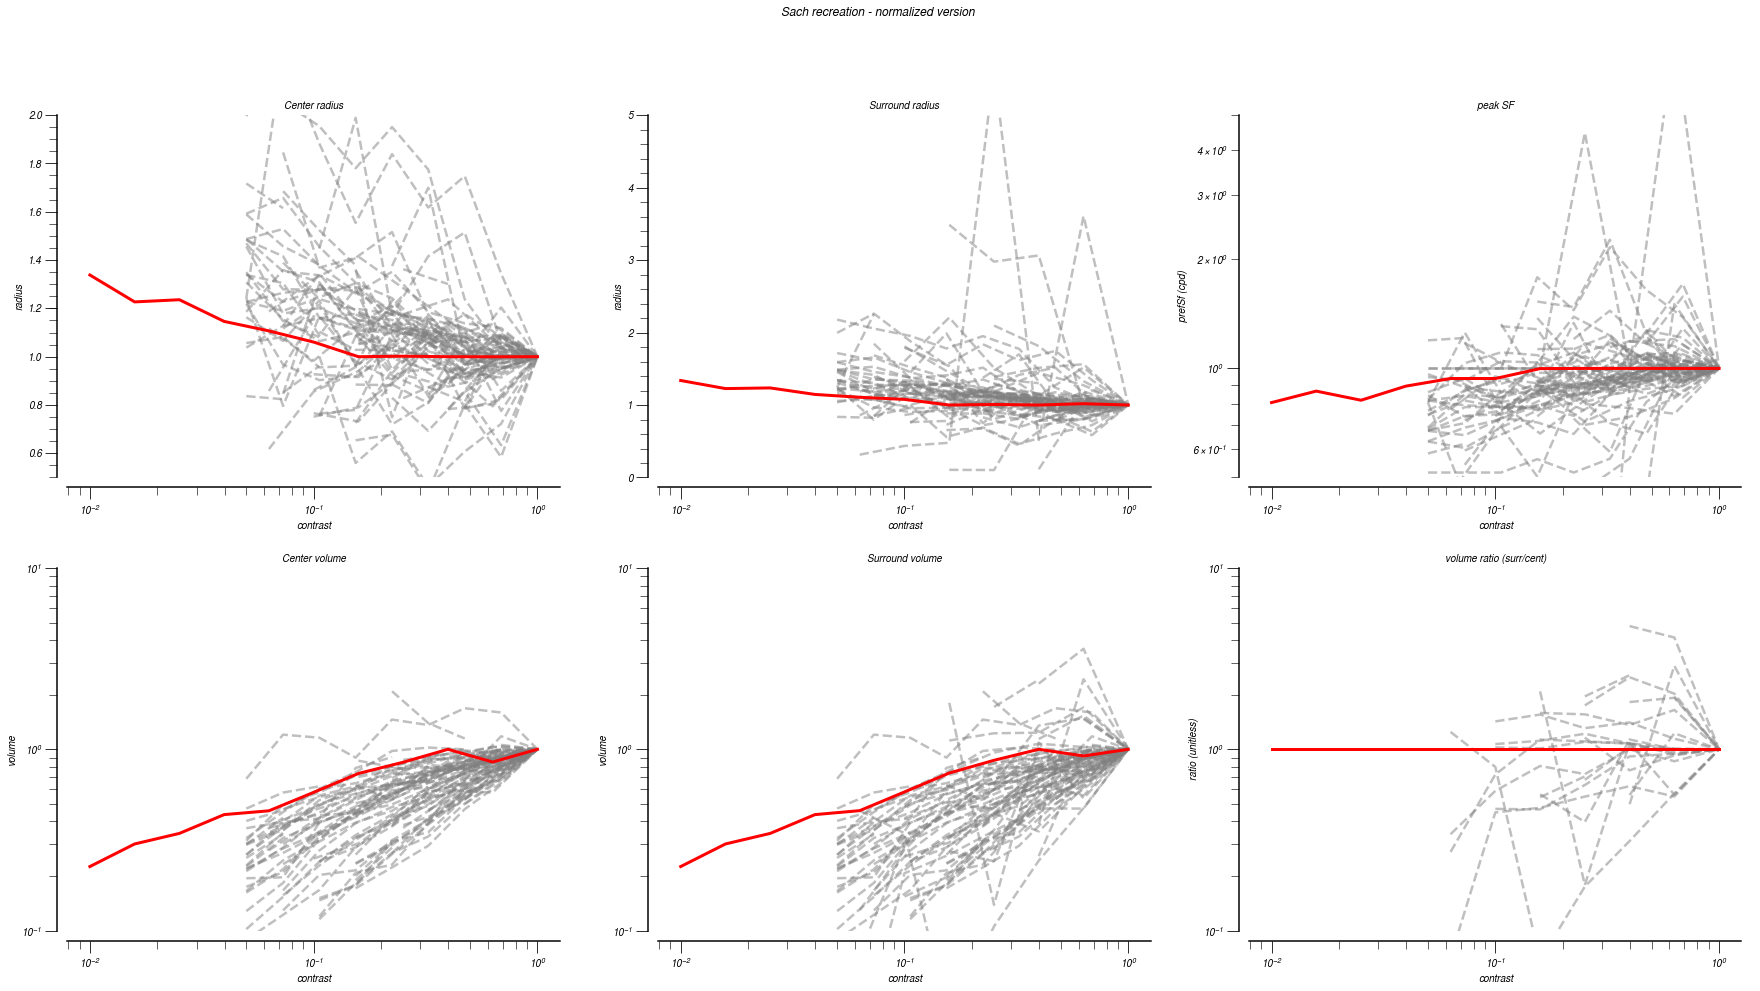

In [133]:
f, ax = plt.subplots(2, 3, figsize=(30, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rc_norm[i, con_inds], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0.5, 2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_rs_norm[i, con_inds], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_psf_norm[i, con_inds], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf_norm, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([5e-1, 5e0]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volc_norm[i, con_inds], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc_norm, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_vols_norm[i, con_inds], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols_norm, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    cons_curr = all_cInds[i] # indices, not values
    con_inds = range(len(cons_curr)); # inds into the overall array, here
    val_cons = all_cVals[i];
    plt.plot(val_cons, all_volrat_norm[i, con_inds], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat_norm, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation - normalized version')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

saveName = "/sach_norm%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Let's plot ratios!

Let's make scatter plots of each the ratios for each cell's tuning - evaluated at highest/lowest valid contrasts

In [134]:
clrs = np.zeros((len(all_types), ), dtype='O');
lbls = np.zeros((len(all_types), ), dtype='O');

myInds = np.where(expNum == 0)
sachInds = np.where(expNum == 1)

clrs[myInds] = 'r';
clrs[sachInds] = 'k';

lbls[myInds] = 'mine';
lbls[sachInds] = 'sach';

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater


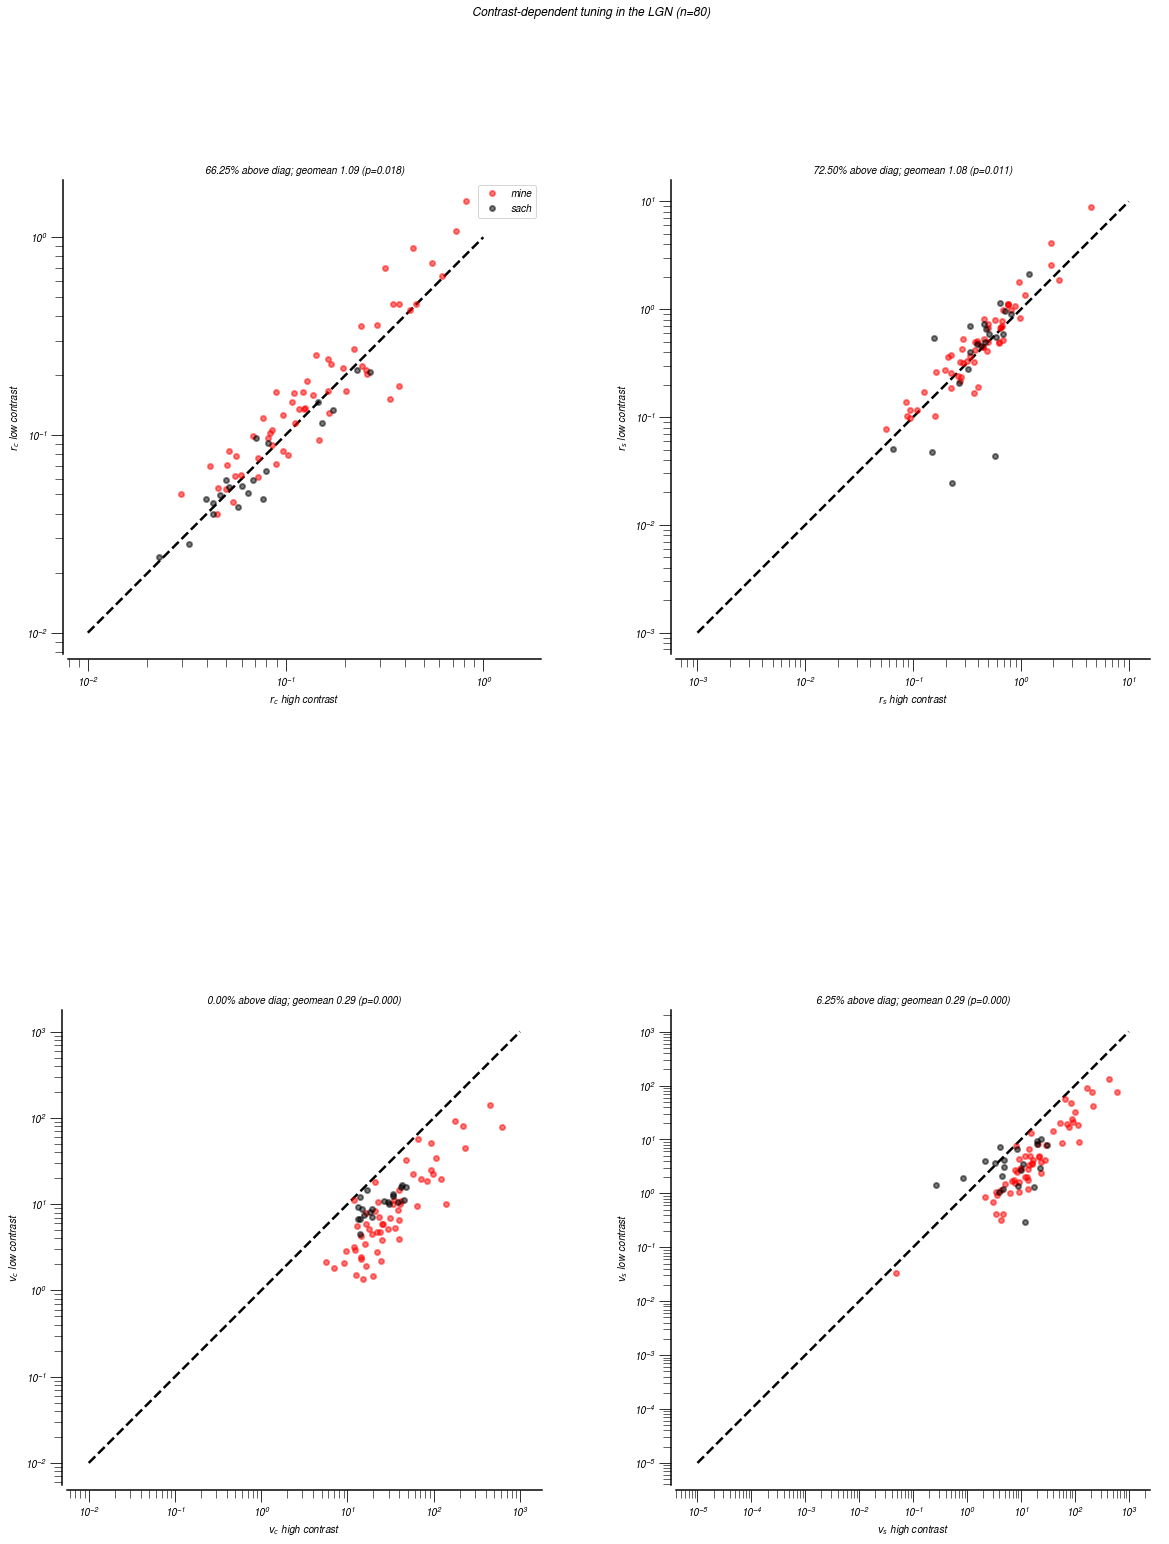

In [135]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    ii = i
    
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
#     ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e0], [1e-2, 1e0], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'o', alpha=0.5, color=clrs[ii], label=lbls[ii]);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-3, 1e1], [1e-3, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'ko', alpha=0.5, color=clrs[ii]);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'ko', alpha=0.5, color=clrs[ii]);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-5, 1e3], [1e-5, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'ko', alpha=0.5, color=clrs[ii]);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));
# -- and legend
ax[0, 0].legend();

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));

f.suptitle('Contrast-dependent tuning in the LGN (n=%d)' % len(non_nan));
f.subplots_adjust(wspace=0.2, hspace=0.75);

saveName = "/dog_conDep%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Now the same, but colored by cell type?

In [136]:
clrs = np.zeros((len(all_types), ), dtype='O');
lbls = np.zeros((len(all_types), ), dtype='O');

In [137]:
mInds = np.where(all_types == 'magno')
pInds = np.where(all_types == 'parvo')
tInds = np.where(all_types == 'tbd')

clrs[mInds] = 'r'
clrs[pInds] = 'k'
clrs[tInds] = 'b'

lbls[mInds] = 'magno'
lbls[pInds] = 'parvo'
lbls[tInds] = 'tbd'

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater


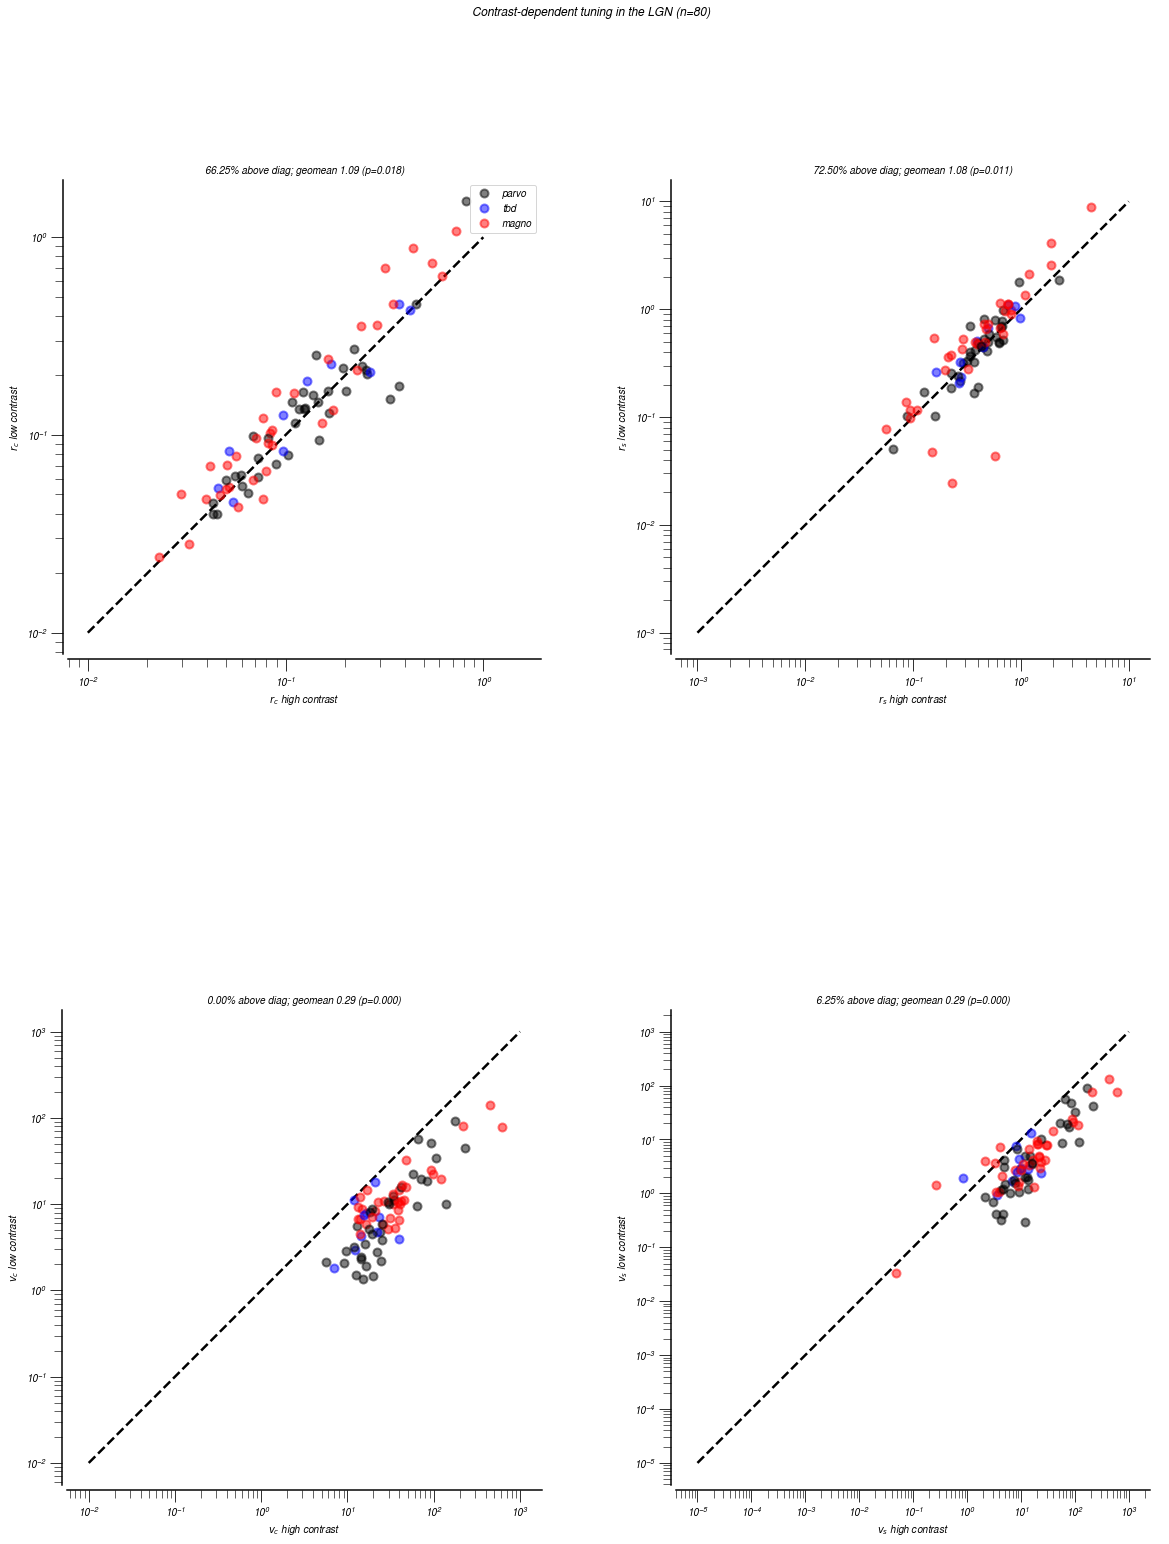

In [138]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    ii = i;
    
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
#     ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e0], [1e-2, 1e0], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'o', alpha=0.5, color=clrs[ii], label=lbls[ii], markersize=8);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-3, 1e1], [1e-3, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'o', alpha=0.5, color=clrs[ii], markersize=8);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'o', alpha=0.5, color=clrs[ii], markersize=8);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-5, 1e3], [1e-5, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'o', alpha=0.5, color=clrs[ii], markersize=8);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));
ax[0, 0].legend();

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (100*surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));

f.suptitle('Contrast-dependent tuning in the LGN (n=%d)' % len(non_nan));
f.subplots_adjust(wspace=0.2, hspace=0.75);

saveName = "/dog_conDep%s%s_byType.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### Compute and plot peak SF

Fix some stuff here with n_cons vs allCons (not all expts have same # of contrasts)

In [142]:
# NOTE: USES FULL descFit, will not work with just params

# # peak SF v. contrast
# n_singleCons = all_psf.shape[1]
# psf_geo = np.nan * np.zeros((n_singleCons, ))
# psf_norm_geo = np.nan * np.zeros((n_singleCons, ))
# for i in range(n_singleCons):
#     non_nans = np.where(~np.isnan(all_psf[:, i]))[0]
#     if len(non_nans) > 0:
#         psf_geo[i] = geomean(all_psf[non_nans, i])
#         psf_norm_geo[i] = geomean(all_psf_norm[non_nans, i])

# ratio of peak SF at high:low contrast
psf_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
psf_ratios_V1 = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    ii = i;
#     #     curr_cons = allCons[i];
#     if i not in descrFits.keys():
#         continue;

    ## TODO: Fix -- all_params is just params, but dog_prefSfMod wants full fit structure
    # // should be able to just 
    psf_ratios[i, 0], psf_model, opt_params = hf.dog_prefSfMod(all_params[i], curr_cons, dog_model=DoGmodel)
    if np.isnan(psf_ratios[i, 0]):
        continue;
    #######    
    # peak ratio only at the v1 contrasts (100% [index -1], 32.5%)
    ######
    singleCons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons
    v1_conInds = [np.argmin(np.square(singleCons-0.33)), np.argmin(np.square(singleCons-1))]

    v1_extrema = psf_model(*opt_params, con=(curr_cons[v1_conInds[0]], curr_cons[v1_conInds[-1]]));
    psf_ratios_V1[i, 0] = v1_extrema[-1] / v1_extrema[0];
    if dataList['unitType'][i] == 'parvo':
        psf_ratios[i, 1] = psf_ratios[i, 0];
        psf_ratios_V1[i, 1] = psf_ratios_V1[i, 0];
    if dataList['unitType'][i] == 'magno':
        psf_ratios[i, 2]  = psf_ratios[i, 0];
        psf_ratios_V1[i, 2] = psf_ratios_V1[i, 0];
    if dataList['unitType'][i] == 'tbd':
        psf_ratios[i, 3] = psf_ratios[i, 0];
        psf_ratios_V1[i, 3] = psf_ratios_V1[i, 0];
        
val_ratios_all = psf_ratios[~np.isnan(psf_ratios[:, 0]), 0]
val_ratios_p = psf_ratios[~np.isnan(psf_ratios[:, 1]), 1]
val_ratios_m = psf_ratios[~np.isnan(psf_ratios[:, 2]), 2]
val_ratios_tbd = psf_ratios[~np.isnan(psf_ratios[:, 3]), 3]

val_ratiosV1_all = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 0]), 0]
val_ratiosV1_p = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 1]), 1]
val_ratiosV1_m = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 2]), 2]
val_ratiosV1_tbd = psf_ratios_V1[~np.isnan(psf_ratios_V1[:, 3]), 3]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

NameError: name 'psf_geo' is not defined

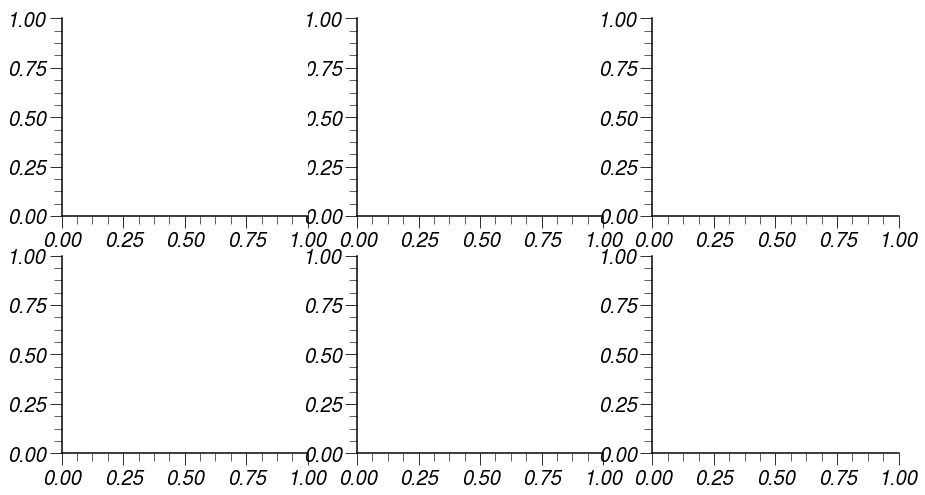

In [39]:
nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
plt.plot(plot_cons, psf_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (cpd)')
plt.title('SF peak');

plt.subplot(nrow, ncol, 2)
plt.plot(plot_cons, psf_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('SF peak - normalized');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('peak SF at high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Parvo SF ratio - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Magno SF ratio - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('TBD SF ratio - %.2f' % ratio_gmean)

f.suptitle('Peak SF response')
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/peakSF%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

NameError: name 'psf_geo' is not defined

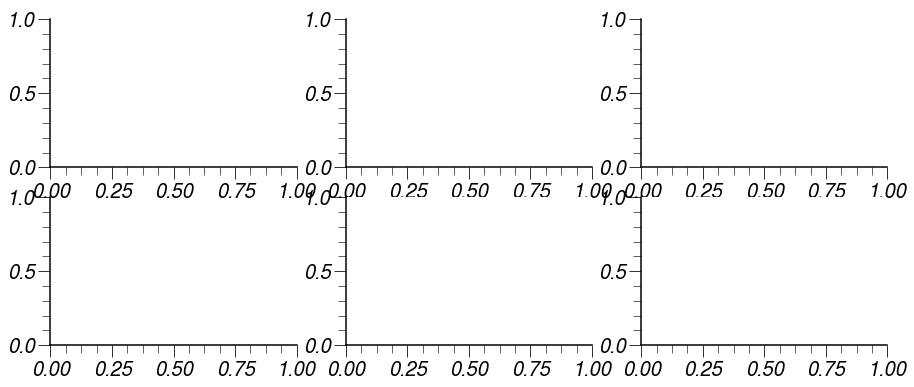

In [40]:
nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(5*ncol, 3*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
plt.plot(plot_cons, psf_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (cpd)')
plt.title('SF peak');

plt.subplot(nrow, ncol, 2)
plt.plot(plot_cons, psf_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('SF peak - normalized');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratiosV1_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('peak SF at high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratiosV1_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Parvo SF ratio - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratiosV1_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('Magno SF ratio - %.2f' % ratio_gmean)

ax = plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 4), np.power(2, 4), 17)
counts, _, _ = plt.hist(val_ratiosV1_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratiosV1_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('pSf ratio')
plt.ylabel('# cells')
plt.title('TBD SF ratio - %.2f' % ratio_gmean)

f.suptitle('Peak SF response - only at V1 contrasts')
f.subplots_adjust(wspace=0.5, hspace=0.75);

sns.despine(offset=10)

saveName = "/peakSF_v1cons%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Relating SF tuning to gain control

We can use phase advance as a proxy for strength of gain control, and relate phase advance to the change in peak contrast, for example

In [145]:
disp = 0; # just do disp = 0 (single gratings)

meanPhAdv =[np.nanmean(phFits[x]['phAdv']) for x in val_cells]
bestPhAdv =[np.nanmax(phFits[x]['phAdv']) for x in val_cells]

meanConGain =[np.nanmean(rvcFits[x][disp]['conGain']) if disp in rvcFits[x] else np.nan for x in val_cells]
bestConGain =[np.nanmax(rvcFits[x][disp]['conGain']) if disp in rvcFits[x] else np.nan for x in val_cells]

meanVarExpl = [np.nanmean(descrFits[x]['varExpl'][0, :]) for x in val_cells]
varAsInd = np.round(meanVarExpl).astype('int32')
varRange = np.max(varAsInd) - np.min(varAsInd);

### Plot characteristic frequency

Characteristic frequency ($1/2\pi r_c$), which we fit, is a measure of the high-frequency cut-off of the SF tuning curve. For cells that are low-pass (rather than bandpass) this is a more reliable measure.

In [146]:
# Center frequency v. contrast
# n_single
# n_singleCons = all_psf.shape[1]

# cfreq_geo = np.nan * np.zeros((n_singleCons, ))
# cfreq_norm_geo = np.nan * np.zeros((n_singleCons, ))
# for i in range(n_singleCons):
#     non_nans = np.where(~np.isnan(all_rc[:, i]))[0]
#     if len(non_nans) > 0:
#         cfreq_geo[i] = geomean(np.divide(1, 2*np.pi*all_rc[non_nans, i]))
# #         cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
#         cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
        
# ratio of peak SF at high:low contrast
cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_cfr[i]))[0]
    #     non_nans = np.where(~np.isnan(all_rc[i, :]))[0];
    if len(non_nans) < 2:
        continue;
        
    min_con = non_nans[0];
    max_con = non_nans[-1];

    cfreq_ratios[i, 0] = all_cfr[i, max_con] / all_cfr[i, min_con];
    if all_types[i] == 'parvo':
        cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
    if all_types[i] == 'magno':
        cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
    if all_types[i] == 'tbd':
        cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

In [147]:
np.argsort(cfreq_ratios[:, 0])

array([ 49,  35, 110,   5, 107,  87,  50,  81,  45,  91,  89,   8,  52,
        46,  88,  10,  15,  14,  63, 105,  80,   4,  56,  99, 108,  98,
       104,  61,  57,  42,  21,  43,  72,  77,  48,  12, 109, 103,  79,
        23,  54,   7,  44, 106,  13,  51,   9,   6,  18,  86,  78,  16,
        11,   3,  68,  28,   2,  70,   0,  75,  62,  90,  60,  29,  20,
        53,  40,  64,  69,  76,  66,  30,  31,  22,  19,  47,  65,  59,
        73,  74,  24, 102, 101, 100,  25,  26,  97,  96,  95,  17,   1,
        94,  93,  84,  27,  67,  41,  71,  39,  38,  37,  92,  36,  33,
        82,  83,  58,  85,  32,  34,  55])

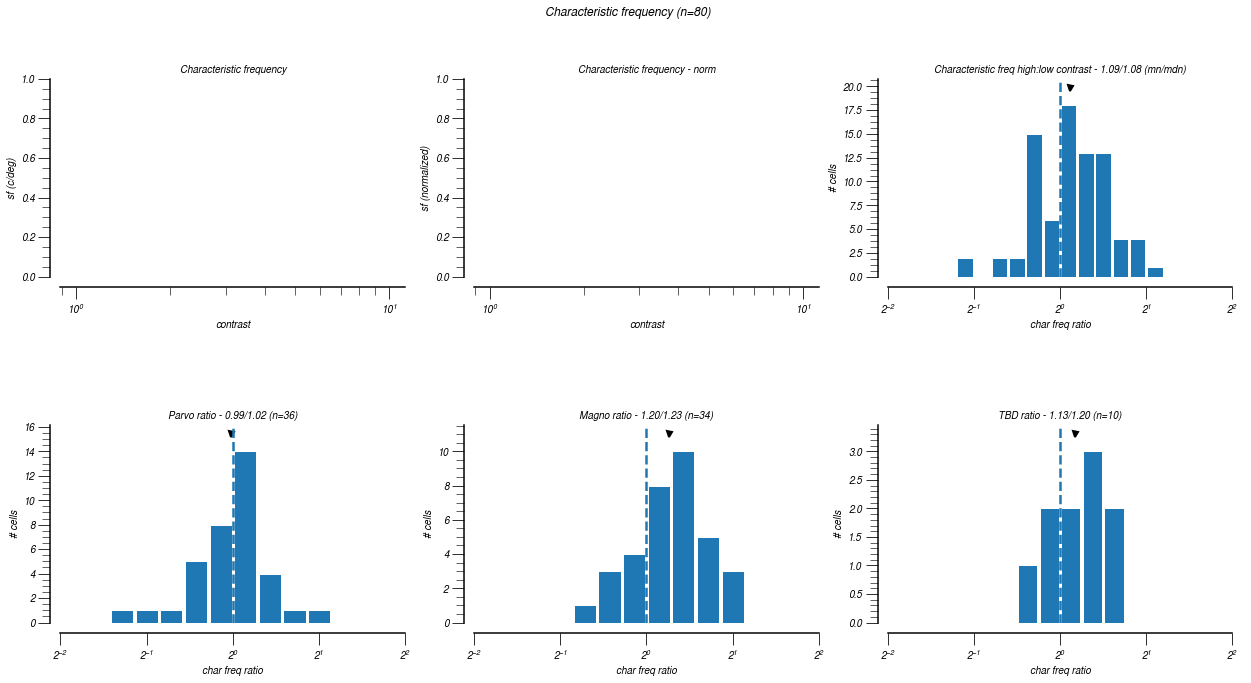

In [149]:
nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Characteristic frequency');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Characteristic frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 21)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_all), np.median(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f/%.2f (mn/mdn)' % (ratio_gmean, mdn))

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_p), np.median(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_p)))
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_m), np.median(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_m)))


plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean, mdn = geomean(val_ratios_tbd), np.median(val_ratios_tbd)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f/%.2f (n=%d)' % (ratio_gmean, mdn, len(val_ratios_tbd)))

f.suptitle('Characteristic frequency (n=%d)' % (len(val_ratios_all)))
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/charFreq%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [150]:
from scipy.stats import ks_2samp as ks2samp

In [151]:
ks2samp(val_ratios_m, val_ratios_p)

Ks_2sampResult(statistic=0.3921568627450981, pvalue=0.006295438728288123)

Now the same, but only at the contrasts used in the V1 experiment (100%, 33%)

*** MUST BE FIXED TO GET PROPER V1 INDEX FOR both types of experiments (mine and Sach...)

In [152]:
singleCons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons
v1_conInds = [np.argmin(np.square(singleCons-0.33)), np.argmin(np.square(singleCons-1))]

In [153]:
# Center frequency v. contrast

cfreq_geo = np.nan * np.zeros((n_singleCons, ))
cfreq_norm_geo = np.nan * np.zeros((n_singleCons, ))
for i in range(n_singleCons):
    non_nans = np.where(~np.isnan(all_rc[:, i]))[0]
    if len(non_nans) > 0:
        cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
        cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
        
    
        
# ratio of peak SF at high:low contrast
cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
for i in range(n_cells):
    non_nans = np.where(~np.isnan(all_rc[i, :]))[0];
    if ~np.any(non_nans == v1_conInds[0]) or ~np.any(non_nans == v1_conInds[1]):
        continue;

    cfreq_ratios[i, 0] = np.divide(1, all_rc[i, max_con]) / np.divide(1, all_rc[i, min_con])
    if all_types[i] == 'parvo':
        cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
    if all_types[i] == 'magno':
        cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
    if all_types[i] == 'tbd':
        cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

NameError: name 'n_singleCons' is not defined

In [ ]:
nrow = 2;
ncol = 3;
f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (c/deg)')
plt.title('Characteristic frequency');

plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
plt.xscale('log')
plt.xlabel('contrast')
plt.ylabel('sf (normalized)')
plt.title('Characteristic frequency - norm');

plt.subplot(nrow, ncol, 3)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_all)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.axvline(1, ls='--')
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Characteristic freq high:low contrast - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 4)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_p)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, 6])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Parvo ratio - %.2f' % ratio_gmean)
# get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest

plt.subplot(nrow, ncol, 5)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_m)
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, 6])
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('Magno ratio - %.2f' % ratio_gmean)

plt.subplot(nrow, ncol, 6)
bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
ratio_gmean = geomean(val_ratios_tbd)
plt.xlim([np.power(2.0, -2), np.power(2, 2)])
plt.ylim([0, 6])
plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
plt.axvline(1, ls='--')
plt.xscale('log', basex=2)
plt.xlabel('char freq ratio')
plt.ylabel('# cells')
plt.title('TBD ratio - %.2f' % ratio_gmean)

f.suptitle('Characteristic frequency - only at V1 contrasts')
f.subplots_adjust(wspace=0.2, hspace=0.75);

sns.despine(offset=10)

saveName = "/charFreq_v1cons%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### Plot pSf, charFreq against conGain, phAdv

In [ ]:
nrow = 6;
ncol = 2;
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*12))

### pSf versus phase advance

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 1)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], bestPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('SF shift versus highest phase advance');

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 2)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], meanPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('SF shift versus mean phase advance');

### pSf versus contrast gain

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 3)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], bestConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('contrast gain');
plt.title('SF shift versus highest conGain');

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 4)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], meanConGain, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('contrast gain');
plt.title('SF shift versus mean conGain');

### charFreq versus phase advance
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 5)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(cfreq_ratios[:, 0], bestPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('charFreq ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('charFreq shift versus highest phase advance');

# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 6)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(cfreq_ratios[:, 0], meanPhAdv, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('charFreq ratio');
plt.yscale('symlog')
plt.ylabel('phase advance (ms)');
plt.title('charFreq shift versus mean phase advance');

### pSf versus center radius change (high:low contrast ratio)
plt.subplot(nrow, ncol, 7)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_rc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('radius ratio');
plt.title('SF shift versus center radius contrast change');

### pSf versus surround radius change
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 8)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_rs_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('symlog')
plt.ylabel('radius ratio');
plt.title('SF shift versus surround radius contrast change');

### pSf versus center volume change
plt.subplot(nrow, ncol, 9)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_volc_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.yscale('log')
plt.ylabel('volume ratio');
plt.title('SF shift versus center volume contrast change');

### pSf versus surround volume change
# point darkness is rel. to variance explained by the DoG fits -- i.e. darker points were fit better
plt.subplot(nrow, ncol, 10)
grays = cm.gray(np.linspace(0, 1, varRange+1))
plt.scatter(psf_ratios[:, 0], all_vols_conRat, color=grays[varRange - (varAsInd - np.min(varAsInd))])
plt.xscale('log')
plt.xlabel('psf ratio');
plt.ylim([1e-1, 1e2])
plt.yscale('log')
plt.ylabel('volume ratio');
plt.title('SF shift versus surround volume contrast change');

sns.despine(offset=10)

saveName = "/peakSF_v_DoG%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Plot high-frequency cut-off

Characteristic frequency ($1/2\pi r_c$), which we fit, is a measure of the high-frequency cut-off of the SF tuning curve. For cells that are low-pass (rather than bandpass) this is a more reliable measure.

But, due to poor difference-of-gaussian fitting and/or the misleading characteristic frequencies that result from effectively flat tuning (which can occur at low contrasts/response amplitudes), we can just compute the frequency at which the response falls to X% of the peak response - this can be a proxy (and perhaps more reliable measure) for the changes in high-frequency

**update** must update to include different response drop-off measure

In [ ]:
# # Center frequency v. contrast
# n_singleCons = all_psf.shape[1]

# cfreq_geo = np.nan * np.zeros((n_singleCons, ))
# cfreq_norm_geo = np.nan * np.zeros((n_singleCons, ))
# for i in range(n_singleCons):
#     non_nans = np.where(~np.isnan(all_psf[:, i]))[0]
#     if len(non_nans) > 0:
#         cfreq_geo[i] = geomean(np.divide(1, 2*np.pi*all_rc[non_nans, i]))
# #         cfreq_geo[i] = geomean(np.divide(1, np.pi*all_rc[non_nans, i]))
#         cfreq_norm_geo[i] = geomean(np.divide(1, all_rc_norm[non_nans, i]))
        
# # ratio of peak SF at high:low contrast
# cfreq_ratios = np.nan * np.zeros((n_cells, 4)) # allCells, Parvo, Magno, TBD separately
# for i in range(n_cells):
#     non_nans = np.where(~np.isnan(all_psf[i, :]))[0];
#     if len(non_nans) == 0:
#         continue;
        
#     min_con = non_nans[0];
#     max_con = non_nans[-1];

#     cfreq_ratios[i, 0] = np.divide(1, all_rc[i, max_con]) / np.divide(1, all_rc[i, min_con])
#     if dataList['unitType'][i] == 'parvo':
#         cfreq_ratios[i, 1] = cfreq_ratios[i, 0];
#     if dataList['unitType'][i] == 'magno':
#         cfreq_ratios[i, 2] = cfreq_ratios[i, 0];
#     if dataList['unitType'][i] == 'tbd':
#         cfreq_ratios[i, 3] = cfreq_ratios[i, 0];

# val_ratios_all = cfreq_ratios[~np.isnan(cfreq_ratios[:, 0]), 0]
# val_ratios_p = cfreq_ratios[~np.isnan(cfreq_ratios[:, 1]), 1]
# val_ratios_m = cfreq_ratios[~np.isnan(cfreq_ratios[:, 2]), 2]
# val_ratios_tbd = cfreq_ratios[~np.isnan(cfreq_ratios[:, 3]), 3]

In [ ]:
# nrow = 2;
# ncol = 3;
# f, ax = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))

# plot_cons = allCons[0][allConByDisp[0][0]]; # I'm using cell "0", but all cells have the same single grating cons

# plt.subplot(nrow, ncol, 1)
# plt.plot(plot_cons, cfreq_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (c/deg)')
# plt.title('Characteristic frequency');

# plt.subplot(nrow, ncol, 2)
# plt.plot(plot_cons, cfreq_norm_geo, 'o')
# plt.xscale('log')
# plt.xlabel('contrast')
# plt.ylabel('sf (normalized)')
# plt.title('Characteristic frequency - norm');

# plt.subplot(nrow, ncol, 3)
# bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 21)
# counts, _, _ = plt.hist(val_ratios_all, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_all)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xlim([np.power(2.0, -2), np.power(2, 2)])
# plt.xscale('log', basex=2)
# plt.xlabel('char freq ratio')
# plt.ylabel('# cells')
# plt.title('Characteristic freq high:low contrast - %.2f' % ratio_gmean)

# plt.subplot(nrow, ncol, 4)
# bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
# counts, _, _ = plt.hist(val_ratios_p, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_p)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xlim([np.power(2.0, -2), np.power(2, 2)])
# plt.xscale('log', basex=2)
# plt.xlabel('char freq ratio')
# plt.ylabel('# cells')
# plt.title('Parvo ratio - %.2f' % ratio_gmean)
# # get the ylimits here to pass on to the next plots - why here? since more parvo cells than anything, so highest
# ylim = plt.gca().get_ylim()

# plt.subplot(nrow, ncol, 5)
# bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 15)
# counts, _, _ = plt.hist(val_ratios_m, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_m)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k');
# plt.axvline(1, ls='--')
# plt.xlim([np.power(2.0, -2), np.power(2, 2)])
# plt.ylim(ylim)
# plt.xscale('log', basex=2)
# plt.xlabel('char freq ratio')
# plt.ylabel('# cells')
# plt.title('Magno ratio - %.2f' % ratio_gmean)


# plt.subplot(nrow, ncol, 6)
# bins = np.geomspace(1.0/np.power(2, 2), np.power(2, 2), 17)
# counts, _, _ = plt.hist(val_ratios_tbd, bins, rwidth=0.9)
# ratio_gmean = geomean(val_ratios_tbd)
# plt.plot(ratio_gmean, 1.1*np.max(counts), 'v', color='k', label='gm=%.2f' % ratio_gmean);
# plt.axvline(1, ls='--')
# plt.xlim([np.power(2.0, -2), np.power(2, 2)])
# plt.ylim(ylim)
# plt.xscale('log', basex=2)
# plt.xlabel('char freq ratio')
# plt.ylabel('# cells')
# plt.title('TBD ratio - %.2f' % ratio_gmean)

# f.suptitle('Characteristic frequency')
# f.subplots_adjust(wspace=0.2, hspace=0.75);

# sns.despine(offset=10)

# # saveName = "/charFreq%s.pdf" % loss_suff
# # full_save = os.path.dirname(save_loc);
# # if not os.path.exists(full_save):
# #     os.makedirs(full_save)
# # pdfSv = pltSave.PdfPages(full_save + saveName);
# # pdfSv.savefig(f) # only one figure here...
# # pdfSv.close()


# Important: Characteristic Frequency analysis as in analyses_Sach.ipynb

To more easily compare my data to Sach's, I'm using the same analysis protocol used in .../LGN/sach/analyses_Sach.ipynb

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hist(all_flatVE[~np.isnan(all_flatVE)], bins=np.linspace(-10, 100, 12))
plt.xlabel('% variance explained');
plt.ylabel('# conditions');
plt.title('Quality of DoG fits');

## TODO: here and throughout, how to bin/plot with different sets of contrasts...

# plt.subplot(1, 2, 2);
# vE_byCon_median = np.zeros((n_singleCons, ));
# vE_byCon_mean = np.zeros((n_singleCons, ));
# for i in range(n_singleCons): # same number of cons for all cells
#     ii = val_cells[i] # as above
#     con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
#     curr_vE = [x[con_inds[i]] for x in all_varExpl];
#     vE_byCon_median[i] = np.nanmedian(curr_vE);
#     vE_byCon_mean[i] = np.nanmean(curr_vE);
# plt.plot(singleCons, vE_byCon_median, label='median')
# plt.plot(singleCons, vE_byCon_mean, label='mean')
# plt.xlabel('contrast');
# plt.ylabel('variance explained');
# plt.title('Name: %s' % fLnameBase);
# plt.legend();

sns.despine(offset=10)

saveName = "/varExpl%s%s.pdf" % (mod_suff, loss_suff);
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
to_thresh = 1;
thresh_varExpl = 70
# thresh_varExpl is set above

if to_thresh == 1:
    valid_inds = np.where(all_flatVE > thresh_varExpl)[0]
else: # or to take all
    valid_inds = np.arange(len(flat_params))
    thresh_varExpl = -np.inf
    
non_nanVar = np.sum(~np.isnan(flat_varExpl)) # some conditions are nan
print('%.1f%% of conditions pass the threshold criteria' % (100*len(valid_inds)/non_nanVar))

In [ ]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

sns.set_style('ticks');

In [ ]:
plt_bycell = 1;
cons_to_use = (np.asarray(0.33), np.asarray(1.0)) # V1 contrasts

rats = [];

if plt_bycell:
    f, ax = plt.subplots(n_cells, 1, figsize=(10, 10*n_cells))
    ff, aaxx = plt.subplots(1, 1, figsize=(10, 4));
    
for i in range(len(val_cells)):
    ii = val_cells[i];
    _, mod, modParams, real_fc, real_fc_cons = hf.dog_charFreqMod(descrFits[ii], singleCons, varThresh=thresh_varExpl, DoGmodel=DoGmodel)
    if mod is None:
        continue;
    
    if plt_bycell:
        ax[i].plot(real_fc_cons, real_fc, 'o');
        ax[i].plot(singleCons, mod(*modParams, con=singleCons));
        ax[i].set_yscale('log');
        ax[i].set_ylabel('characteristic frequency');
        ax[i].set_xlabel('contrast')
        ax[i].set_title('cell %d' % (ii+1))
        sns.despine(ax=ax[i], offset=4)
        
        aaxx.plot(singleCons, mod(*modParams, con=singleCons), alpha=0.5); 
        aaxx.set_yscale('log')
        
    extrema = mod(*modParams, con=cons_to_use) # evaluating the model fit at "cons_to_use"
    rat = extrema[-1] / extrema[0]
    # now, make sure we only add the ratio if we have more than 
    if sum(real_fc_cons > 0.2) > 2:
        rats.append(rat);

In [ ]:
rcParams['xtick.major.size'] = 12
rcParams['xtick.minor.size'] = 8
rcParams['xtick.labelsize'] = 'large'

rcParams['ytick.major.size'] = 12
rcParams['ytick.minor.size'] = 8
rcParams['ytick.labelsize'] = 'large'


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

binRange = (-1.0, 1) # in log2 space...
nBins = 15;
bins = np.geomspace(np.power(2, binRange[0]), np.power(2, binRange[1]), nBins);

wghts = np.ones_like(rats)/float(len(rats));
counts, _, _ = plt.hist(rats, bins=bins, weights=wghts, rwidth=0.75, color='b');
gmean = geomean(rats)
plt.plot(gmean, 1.1*np.max(counts), 'v', color='b', markersize=12, label='$\mu = %.2f$\n$n = %d$' % (gmean, len(rats)));
plt.axvline(1, ls='--', color='k');

plt.legend(frameon=False, fontsize=15, handlelength=0);

plt.xlim([bins[0], bins[-1]])
plt.xscale('log', basex=2)

plt.xlabel('Ratio of characteristic frequency', fontsize='large');
plt.ylabel('Proportion of cells', fontsize='large');
plt.suptitle('charfreq ratio: %.2f:%.2f %%con' % (cons_to_use[-1], cons_to_use[0]));
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

sns.despine(offset=15)
f.subplots_adjust(bottom=0.2, left=0.3);

saveName = "/charFreq_v1consInterpAlt%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Test: contrast gain versus SF

In [ ]:
f, ax = plt.subplots(n_cells, 1, figsize=(10, 10*n_cells))
ff, aaxx = plt.subplots(1, 1, figsize=(20, 20));
    
for i in range(len(val_cells)):
    ii = val_cells[i];
    
    curr_sfs = allSfs[ii];
    curr_gains = all_conGain[ii];

    ax[i].set_title('cell %d' % (ii+1))

    if np.isnan(curr_gains).all():
        continue;
    
    sns.despine(ax=ax[i], offset=4)
    
    ax[i].plot(curr_sfs, curr_gains, '-o', label='con. gain');
    ax[i].set_xscale('log');
    ax[i].set_yscale('symlog', linthreshy=1);
    ax[i].set_ylabel('contrast gain');
    ax[i].set_xlabel('sf (c/deg)')

    # now, on the plot for each cell separately, let's plot a re-scaled version of the SF tuning
    sfref_curr = allSfRef[ii];
    mn, mx = np.min(sfref_curr), np.max(sfref_curr);
    mn_gn, mx_gn = np.min(curr_gains), np.max(curr_gains);
    curr_range, needed_range = (mx-mn), (mx_gn-mn_gn)
    ax[i].plot(curr_sfs, mn_gn + needed_range*np.divide(sfref_curr-mn, curr_range), '--', label='tuning (rescaled)')
    ax[i].legend();
    
    aaxx.plot(curr_sfs, curr_gains, alpha=0.5);
    aaxx.set_yscale('log')
    aaxx.set_xscale('log')
    
saveName = "/conGain_wSF%s%s.pdf" % (mod_suff, loss_suff)
full_save = os.path.dirname(save_loc);
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

# Test of linearity

We designed this stimulus set with the explicit intention of testing the linearity of summation in the LGN. Each component of the mixture stimuli is also presented in isolation, and we can predict the mixture response by simply summing up the responses to the mixture components when presented in isolation.

In [ ]:
# cs = hf.np_smart_load(dataPath + dataList['unitName'][i] + '_sfm.npy');
# data = cellStruct['sfm']['exp']['trial'];
# rvcFitsCurr = rvcFits[i];

# # organize adjusted responses
# f1Mean, f1MeanByTrial, f1MeanAll, f1Pred = hf.organize_adj_responses(data, rvcFits[i]);

# # get all mixture trials
# val_trials = np.where(data['num_comps'] == 5);
# isolResp, _, _, _ = hf.get_isolated_responseAdj(data, val_trials, f1MeanByTrial);

In [ ]:
# for i in rvcFits:
#     cs = hf.np_smart_load(dataPath + dataList['unitName'][i] + '_sfm.npy');
#     data = cellStruct['sfm']['exp']['trial'];
#     rvcFitsCurr = rvcFits[i];
    
#     # organize adjusted responses
#     f1Mean, f1MeanByTrial, f1MeanAll, f1Pred = helper_fcns.organize_adj_responses(data, rvcFits[which_cell-1]);
    
#     # get all mixture trials
#     val_trials = np.where(data['num_comps'] == 5);
#     isolResp, _, _, _ = helper_fcns.get_isolated_responseAdj(data, val_trials, f1MeanByTrial);
    
# #     mixResps = f1MeanAll[d, :, :];

### Quick aside: V1 diff-of-gauss?

In [48]:
expDir = 'V1/';
dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/%sstructures/' % expDir;
dataList = hf.np_smart_load(dataPath + hf.get_datalist(expDir));

In [49]:
dir = 1;
rvcBase = 'rvcFits_191023';
rvcMod = 1;
rvcFits = hf.np_smart_load(dataPath + hf.rvc_fit_name(rvcBase, modNum=rvcMod, dir=1))

In [50]:
loss_type = 4;
loss_suff = '_loss%s' % hf.lossType_suffix(loss_type).replace('.npy', '') # for save name ONLY
DoGmodel = 2;
fLnameBase = 'descrFits_191023'

descrFits = hf.np_smart_load(dataPath + hf.descrFit_name(loss_type, fLnameBase, hf.descrMod_name(DoGmodel)))

In [51]:
nCells = len(rvcFits.keys());

allDisps = []; allCons = []; allSfs = []; allConByDisp =[]; allSfRef = [];

for cellNum in range(nCells):

    cellName = dataList['unitName'][cellNum];
    cellStruct = hf.np_smart_load(dataPath +  cellName + '_sfm.npy');
    data = cellStruct['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(dataPath, cellName)[0]
    _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(data, expInd)

    spks = hf.get_adjusted_spikerate(data, cellNum+1, expInd, dataPath, rvcBase, rvcMod, force_f1=True); #force F1, since we're in LGN
    _, _, respOrg, _ = hf.organize_resp(spks, data, expInd, respsAsRate=True);
    sfRef = respOrg[0, :, -1]; # 0 disp, highest contrast
        
    allDisps.append(stimVals[0])
    allCons.append(stimVals[1])
    allSfs.append(stimVals[2])
    allConByDisp.append(val_con_by_disp);
    # let's also save high contrast, single grating SF tuning
    allSfRef.append(sfRef);
    

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2317: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2340: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2213: ComplexWarning: Casting complex values to real discards the imaginary part
  modRespOrg[d, sf, con, 0:nTrCurr] = np.divide(modResp[valid_tr], divFactor);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2340: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2340: UserWarning: Tried to access f1 a

In [52]:
val_cells = sorted(descrFits.keys())

all_params = [descrFits[x]['params'][0] for x in val_cells]
flat_params = np.asarray(hf.flatten_list(all_params))
all_varExpl = [descrFits[x]['varExpl'][0] for x in val_cells]
flat_varExpl = np.asarray(hf.flatten_list(all_varExpl));
all_prefSf = [descrFits[x]['prefSf'][0] for x in val_cells]
flat_prefSf = np.asarray(hf.flatten_list(all_varExpl));
all_NLL = [descrFits[x]['NLL'][0] for x in val_cells]
flat_NLL = np.asarray(hf.flatten_list(all_NLL));

n_cells = len(all_params);
n_cons = np.array([len(allConByDisp[x][0]) for x in val_cells])
max_nCons = np.max(n_cons)

In [53]:
### NOTE: Sach uses 70% as his varExpl cut-off
thresh_varExpl = 70; # i.e. what is the threshold for variance explained for counting that fit/params in the analysis?
valid_inds = np.where(flat_varExpl > thresh_varExpl)[0]

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Now, gather the indices for all valid (i.e. supra-variance-explained-threshold) conditions

In [54]:
gain_c = [hf.dog_get_param(x, DoGmodel, 'gc') for x in flat_params[valid_inds]]
gain_s = [hf.dog_get_param(x, DoGmodel, 'gs') for x in flat_params[valid_inds]]

gain_ratio = np.divide(gain_c, gain_s);

# radius
rad_c = [hf.dog_get_param(x, DoGmodel, 'rc') for x in flat_params[valid_inds]]
rad_s = [hf.dog_get_param(x, DoGmodel, 'rs') for x in flat_params[valid_inds]]

rad_ratio = np.divide(rad_c, rad_s);

In [55]:
''' To be used if analyzing all parameter values (i.e. not flattened/subsetted)
# gain
gain_c = [[x[ind_gain_c] for x in c] for c in all_params]
gain_s = [[x[ind_gain_s] for x in c] for c in all_params]

gain_ratio = np.divide(gain_c, gain_s);
gain_ratio = gain_ratio[~np.isnan(gain_ratio)]

# frequency
freq_c = [[x[ind_freq_c] for x in c] for c in all_params]
freq_s = [[x[ind_freq_s] for x in c] for c in all_params]

freq_ratio = np.divide(freq_c, freq_s);
freq_ratio = freq_ratio[~np.isnan(freq_ratio)]
'''

' To be used if analyzing all parameter values (i.e. not flattened/subsetted)\n# gain\ngain_c = [[x[ind_gain_c] for x in c] for c in all_params]\ngain_s = [[x[ind_gain_s] for x in c] for c in all_params]\n\ngain_ratio = np.divide(gain_c, gain_s);\ngain_ratio = gain_ratio[~np.isnan(gain_ratio)]\n\n# frequency\nfreq_c = [[x[ind_freq_c] for x in c] for c in all_params]\nfreq_s = [[x[ind_freq_s] for x in c] for c in all_params]\n\nfreq_ratio = np.divide(freq_c, freq_s);\nfreq_ratio = freq_ratio[~np.isnan(freq_ratio)]\n'

In [56]:
print('Of %d gain ratios, %.1f%% are greater than 1 (i.e. c > s)\n' % (len(gain_ratio), 100*sum(gain_ratio>1)/len(gain_ratio)))
print('Of %d radius ratios, %.1f%% are less than 1 (i.e. c < s)\n' % (len(rad_ratio), 100*sum(rad_ratio<1)/len(rad_ratio)))

Of 179 gain ratios, 100.0% are greater than 1 (i.e. c > s)

Of 179 radius ratios, 96.6% are less than 1 (i.e. c < s)



Now, let's plot the trajectory of each parameter (and peak SF) with contrast, as split by cell

In [57]:
all_rc = np.nan * np.zeros((n_cells, max_nCons));
all_rs = np.nan * np.zeros((n_cells, max_nCons));
all_gc = np.nan * np.zeros((n_cells, max_nCons));
all_gs = np.nan * np.zeros((n_cells, max_nCons));
all_psf = np.nan * np.zeros((n_cells, max_nCons));
all_volc = np.nan * np.zeros((n_cells, max_nCons));
all_vols = np.nan * np.zeros((n_cells, max_nCons));
all_volrat = np.nan * np.zeros((n_cells, max_nCons));

# and make space for normalized values of the same, where we normalize to the parameter value at the highest valid contrast
all_rc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_rs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_gs_norm = np.nan * np.zeros((n_cells, max_nCons));
all_psf_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volc_norm = np.nan * np.zeros((n_cells, max_nCons));
all_vols_norm = np.nan * np.zeros((n_cells, max_nCons));
all_volrat_norm = np.nan * np.zeros((n_cells, max_nCons));

# and contrast ratios...
all_rc_conRat = np.nan * np.zeros((n_cells, ))
all_rs_conRat = np.nan * np.zeros((n_cells, ))
all_volc_conRat = np.nan * np.zeros((n_cells, ))
all_vols_conRat = np.nan * np.zeros((n_cells, ))

In [58]:
# here, organize and compute everything we need
for i in range(n_cells):
    # take into account that not all cells are in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
    ii = val_cells[i]
    cons_curr = allConByDisp[ii][0];
    con_inds = range(len(cons_curr));
    # messy list comprehension, but basically only get the parameter if that fit meets the variance explained thresh
    all_rc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_rs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'rs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gc[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gc') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_gs[i, con_inds] = [hf.dog_get_param(all_params[i][c], DoGmodel, 'gs') if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    all_psf[i, con_inds] = [all_prefSf[i][c] if all_varExpl[i][c] > thresh_varExpl else np.nan for c in cons_curr]
    # now compute volumes, ratio of volumes
    all_volc[i, con_inds] = np.multiply(all_gc[i, con_inds], np.square(all_rc[i, con_inds]))
    all_vols[i, con_inds] = np.multiply(all_gs[i, con_inds], np.square(all_rs[i, con_inds]))
    all_volrat[i, con_inds] = np.divide(all_vols[i, con_inds], all_volc[i, con_inds])
    
    if np.all(np.isnan(all_rc[i, :])): # don't normalize if they're all NaN
        continue;
    highest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][-1];
    lowest_valIndex = np.where(~np.isnan(all_rc[i, con_inds]))[0][0];
    all_rc_norm[i, con_inds] = np.divide(all_rc[i, con_inds], all_rc[i, highest_valIndex]);
    all_rs_norm[i, con_inds] = np.divide(all_rs[i, con_inds], all_rs[i, highest_valIndex]);
    all_gc_norm[i, con_inds] = np.divide(all_gc[i, con_inds], all_gc[i, highest_valIndex]);
    all_gs_norm[i, con_inds] = np.divide(all_gs[i, con_inds], all_gs[i, highest_valIndex]);
    all_psf_norm[i, con_inds] = np.divide(all_psf[i, con_inds], all_psf[i, highest_valIndex]) 
    # now compute volumes, ratio of volumes
    all_volc_norm[i, con_inds] = np.divide(all_volc[i, con_inds], all_volc[i, highest_valIndex])
    all_vols_norm[i, con_inds] = np.divide(all_vols[i, con_inds], all_vols[i, highest_valIndex])
    all_volrat_norm[i, con_inds] = np.divide(all_volrat[i, con_inds], all_volrat[i, highest_valIndex])

    # measure ratio of center, surround radii at highest/lowest contrast; same for volumes
    all_rc_conRat[i] = all_rc[i, highest_valIndex]/all_rc[i, lowest_valIndex];
    all_rs_conRat[i] = all_rs[i, highest_valIndex]/all_rs[i, lowest_valIndex];
    all_volc_conRat[i] = all_volc[i, highest_valIndex]/all_volc[i, lowest_valIndex];
    all_vols_conRat[i] = all_vols[i, highest_valIndex]/all_vols[i, lowest_valIndex];

#### Parameter trends versus contrast

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


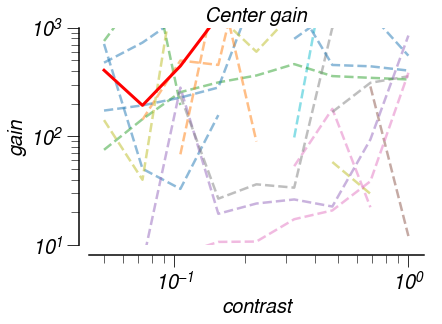

In [59]:
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc[i, :], '--', alpha=0.5)
gc_medians = np.nanmedian(all_gc, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([1e1, 1e3])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range
sns.despine(offset=10)

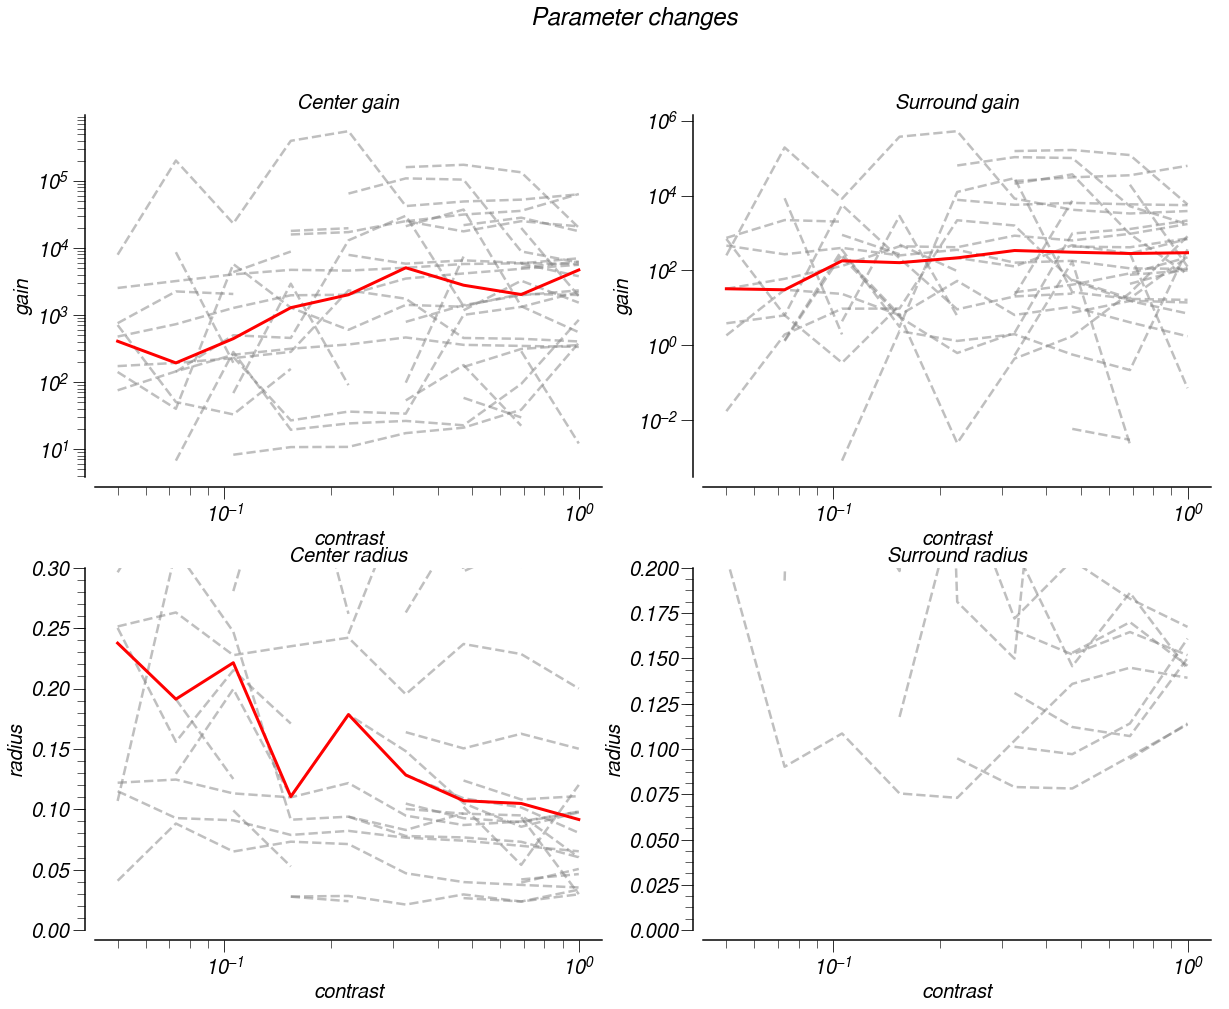

In [60]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5) # mean gray

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc[i, :], '--', color=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
# plt.ylim([0, 75])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Center gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gs[i, :], '--', color=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs, 0);
plt.plot(val_cons, gs_medians, 'r', linewidth=3)
# plt.ylim([10e0, 10e3])
plt.xlabel('contrast');
plt.ylabel('gain')
plt.title('Surround gain')
plt.xscale('log')
plt.yscale('log') # just for better visibility, given the wide range

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 0.2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/DoG_params%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

The center (and, to a lesser extent, the surround) gain increases steadily with contrast. The center and surround radii seem relatively constant. These findings, though, are obscured by the different cells which contribute to each of the median values - i.e. cells 1, 3, 5 might contribute to lowest contrast, and 2, 4, 5 to the highest -- they each have their own range of values, so a "raw" median/trend might be misleading.

#### Normalized trends

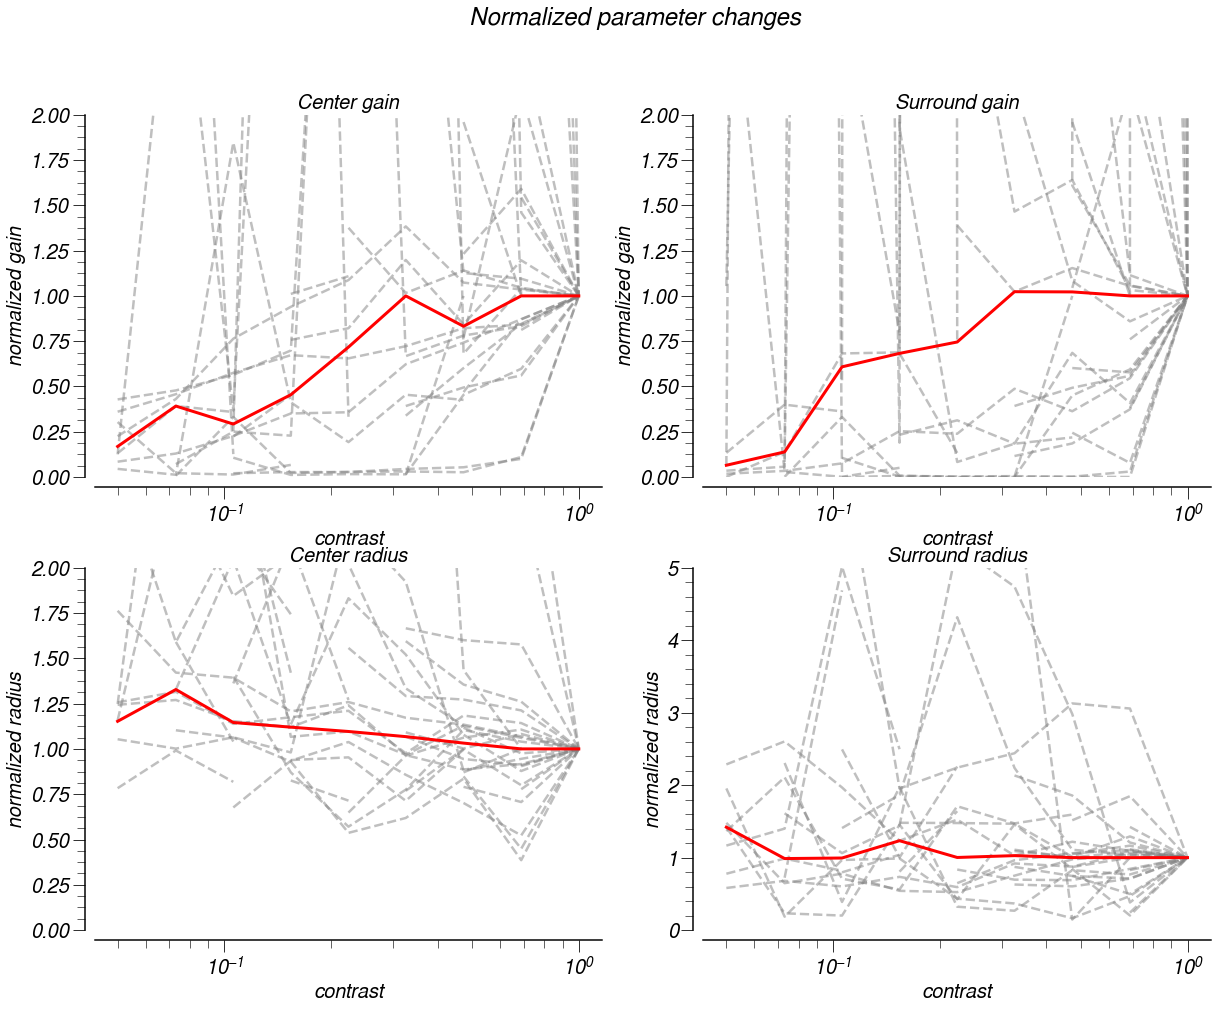

In [61]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

gray = cm.gray(0.5)

# center gain
plt.subplot(2, 2, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gc_norm[i, :], '--', c=gray, alpha=0.5)
gc_medians = np.nanmedian(all_gc_norm, 0);
plt.plot(val_cons, gc_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Center gain')
plt.xscale('log')

# surround gain
plt.subplot(2, 2, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_gs_norm[i, :], '--', c=gray, alpha=0.5)
gs_medians = np.nanmedian(all_gs_norm, 0);
plt.plot(val_cons, gs_medians, 'r', linewidth=3)
plt.ylim([0, 2])
plt.xlabel('contrast');
plt.ylabel('normalized gain')
plt.title('Surround gain')
plt.xscale('log')

# center radius
plt.subplot(2, 2, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc_norm[i, :], '--', c=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 2]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Center radius')
plt.xscale('log')

# surround radius
plt.subplot(2, 2, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs_norm[i, :], '--', c=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('normalized radius')
plt.title('Surround radius')
plt.xscale('log')

f.suptitle('Normalized parameter changes')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/DoG_params_norm%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

Now, a more clear picture emerges: gain increases with contrast, and radius - both center and surround - decrease with contrast. This is what Sach finds (plots/reports only on the radius change).

### Reproduce Sach's figure 3-3

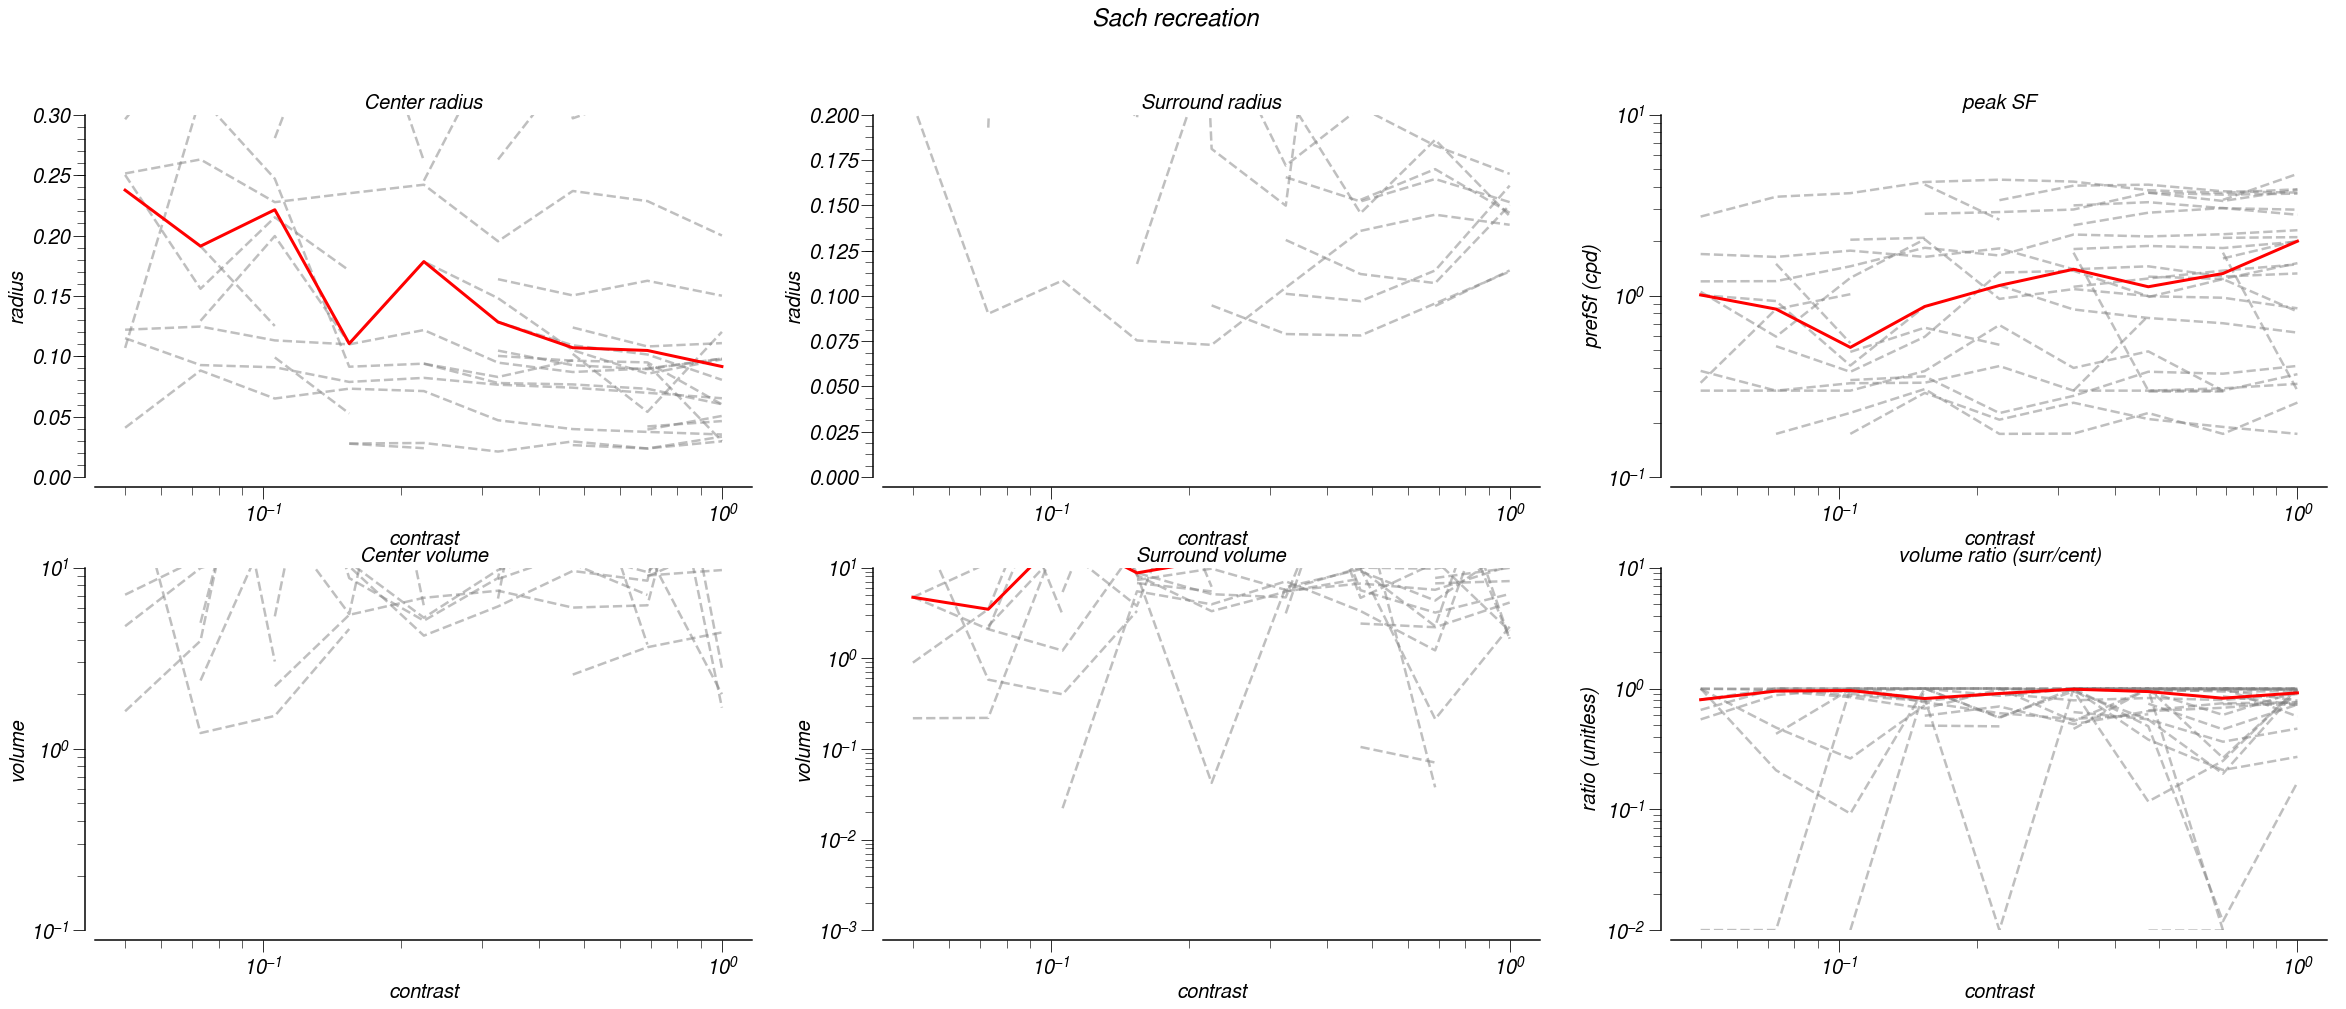

In [62]:
f, ax = plt.subplots(2, 3, figsize=(40, 15))

gray = cm.gray(0.5) # mean gray

# center radius
plt.subplot(2, 3, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 0.3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround radius
plt.subplot(2, 3, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 0.2]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_psf[i, :], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volc[i, :], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_vols[i, :], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e-3, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volrat[i, :], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-2, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/sach%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

Now, the normalized version

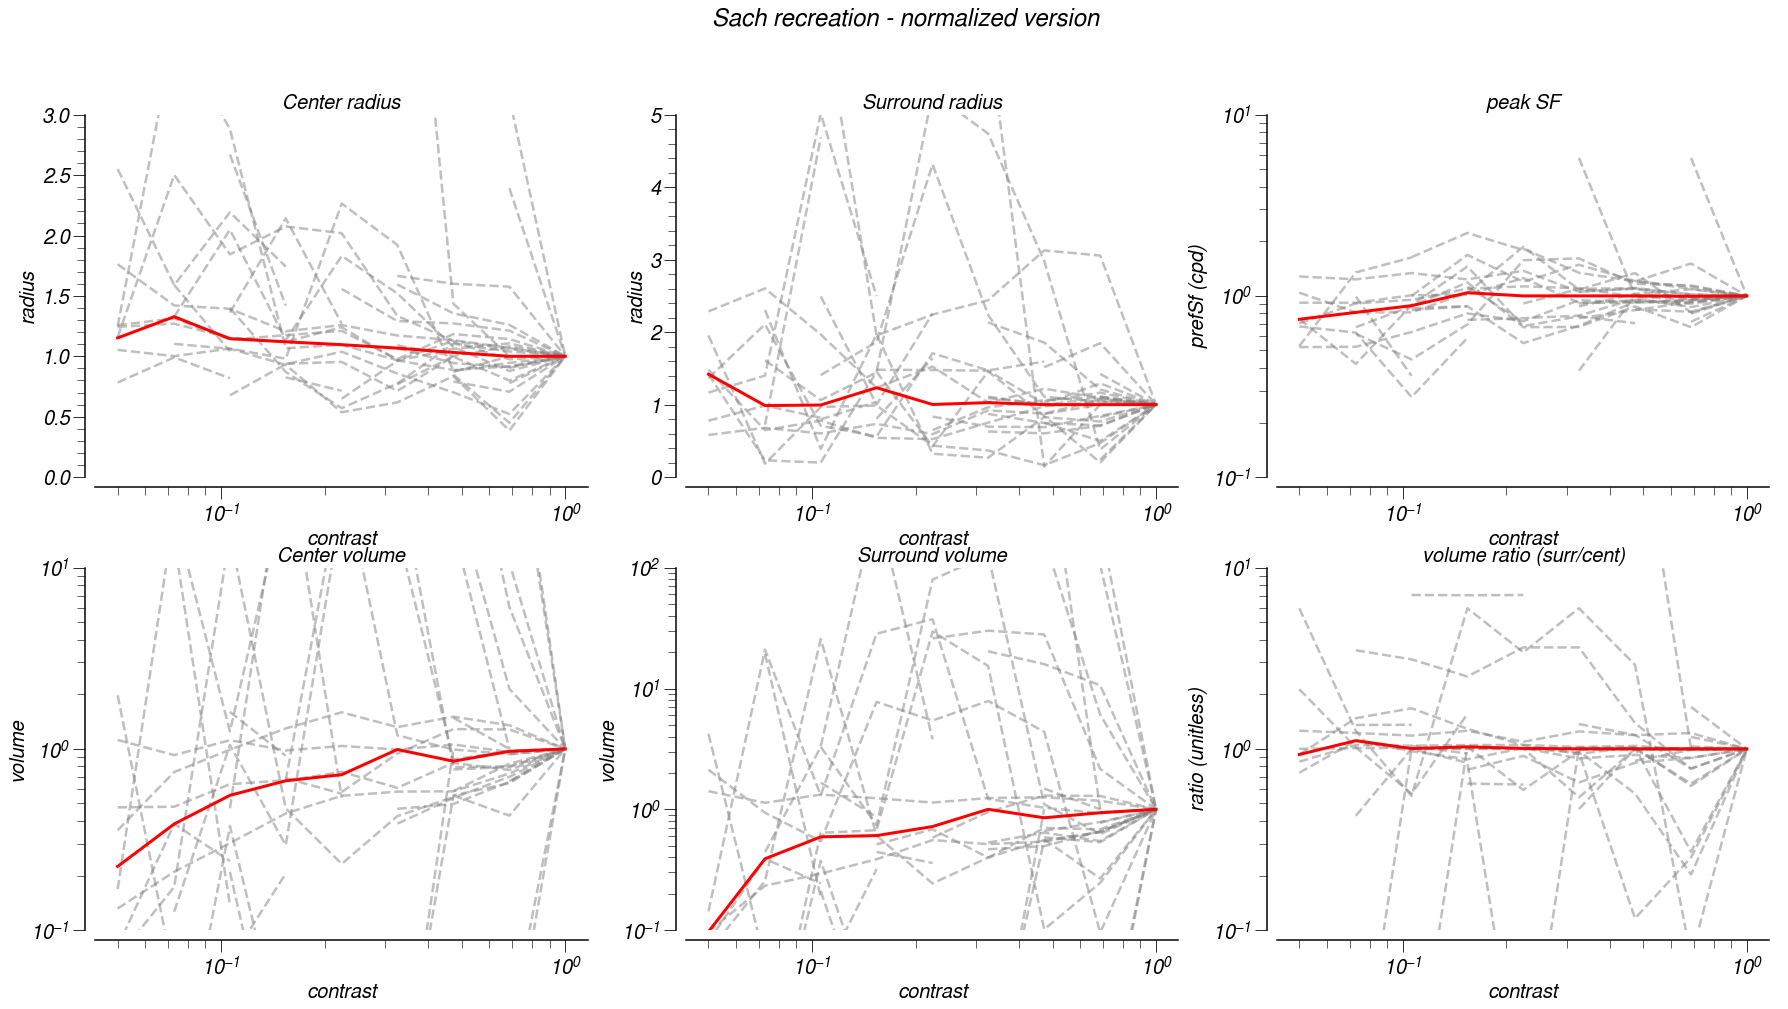

In [63]:
f, ax = plt.subplots(2, 3, figsize=(30, 15))

gray = cm.gray(0.5) # mean gray

# center freq
plt.subplot(2, 3, 1);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rc_norm[i, :], '--', color=gray, alpha=0.5)
rc_medians = np.nanmedian(all_rc_norm, 0);
plt.plot(val_cons, rc_medians, 'r', linewidth=3)
plt.ylim([0, 3]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Center radius')
plt.xscale('log')
    
# surround freq
plt.subplot(2, 3, 2);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_rs_norm[i, :], '--', color=gray, alpha=0.5)
rs_medians = np.nanmedian(all_rs_norm, 0);
plt.plot(val_cons, rs_medians, 'r', linewidth=3)
plt.ylim([0, 5]);
plt.xlabel('contrast');
plt.ylabel('radius')
plt.title('Surround radius')
plt.xscale('log')

# peak SF
plt.subplot(2, 3, 3);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_psf_norm[i, :], '--', color=gray, alpha=0.5)
psf_medians = np.nanmedian(all_psf_norm, 0);
plt.plot(val_cons, psf_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('prefSf (cpd)')
plt.title('peak SF')
plt.xscale('log')
plt.yscale('log')

# center volume
plt.subplot(2, 3, 4);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volc_norm[i, :], '--', color=gray, alpha=0.5)
vc_medians = np.nanmedian(all_volc_norm, 0);
plt.plot(val_cons, vc_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Center volume')
plt.xscale('log')
plt.yscale('log')

# surround volume
plt.subplot(2, 3, 5);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_vols_norm[i, :], '--', color=gray, alpha=0.5)
vs_medians = np.nanmedian(all_vols_norm, 0);
plt.plot(val_cons, vs_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e2]);
plt.xlabel('contrast');
plt.ylabel('volume')
plt.title('Surround volume')
plt.xscale('log')
plt.yscale('log')

# volume ratio
plt.subplot(2, 3, 6);
for i in range(n_cells):
    ii = val_cells[i] # as above
    con_inds = allConByDisp[ii][0]; # single gratings, hence "0"
    val_cons = allCons[ii][con_inds]
    plt.plot(val_cons, all_volrat_norm[i, :], '--', color=gray, alpha=0.5)
volrat_medians = np.nanmedian(all_volrat_norm, 0);
plt.plot(val_cons, volrat_medians, 'r', linewidth=3)
plt.ylim([1e-1, 1e1]);
plt.xlabel('contrast');
plt.ylabel('ratio (unitless)')
plt.title('volume ratio (surr/cent)')
plt.xscale('log')
plt.yscale('log')

f.suptitle('Sach recreation - normalized version')
f.subplots_adjust(wspace=0.2, hspace=0.25);

sns.despine(offset=10)

# saveName = "/sach_norm%s.pdf" % loss_suff
# full_save = os.path.dirname(save_loc);
# if not os.path.exists(full_save):
#     os.makedirs(full_save)
# pdfSv = pltSave.PdfPages(full_save + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

### Let's plot ratios!

Let's make scatter plots of each the ratios for each cell's tuning - evaluated at highest/lowest valid contrasts

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater


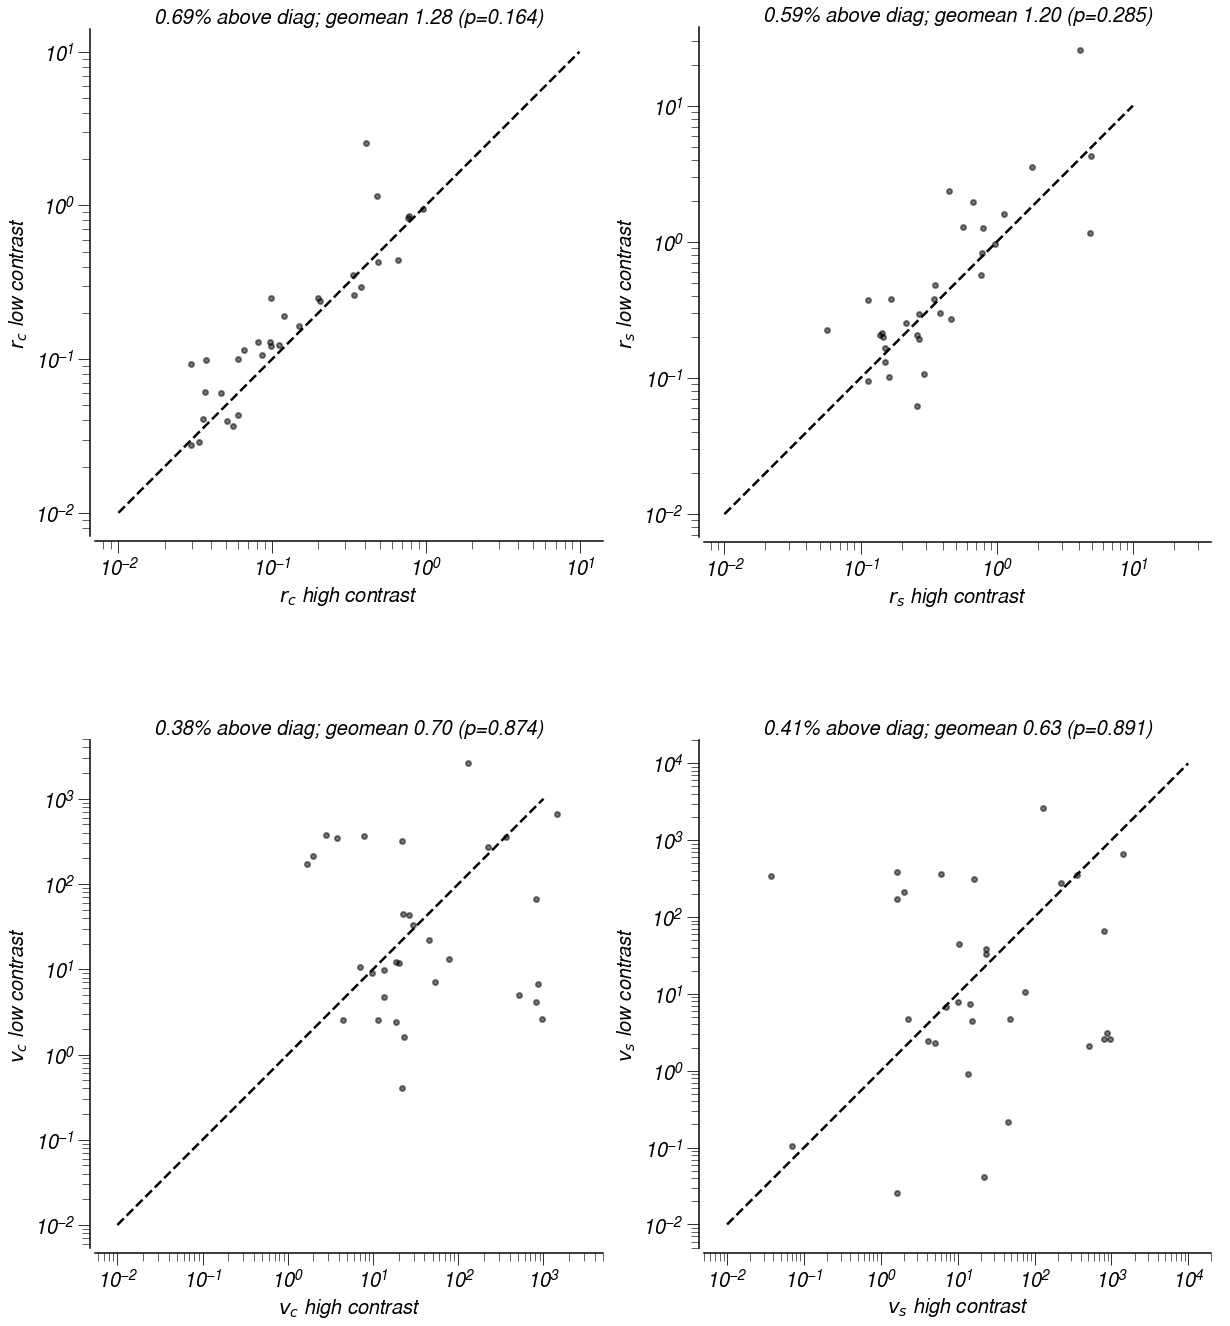

In [64]:
ctrR_rats = np.nan*np.zeros((n_cells, ));
surR_rats = np.nan*np.zeros((n_cells, ));
ctrVol_rats = np.nan*np.zeros((n_cells, ));
surVol_rats = np.nan*np.zeros((n_cells, ));
# also save the indices into all_* for later analysis
extremaInds = np.zeros((n_cells, 2), dtype='int32');

nr, nc = 2, 2;
f, ax = plt.subplots(nr, nc, figsize=(10*nc, 12*nr))

for i in range(n_cells):
    # take into account that not all cells are necessarily in descrFits, but all will be in all[Con[[byDisp]]][sf][disp]
    ii = val_cells[i]

    ### center radius - and generally, which contrasts are valid (i.e. varExpl above threshold)
    curr_radii = all_rc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 0].set_xlabel('$r_c$ high contrast')
        ax[0, 0].set_ylabel('$r_c$ low contrast')
        ax[0, 0].plot([1e-2, 1e1], [1e-2, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 0])
    # now, get the actual data
    non_nan = np.where(~np.isnan(curr_radii))[0];
    if len(non_nan) < 2:
        continue;
    extrema_ind = [non_nan[0], non_nan[-1]] # low con, high con
    extremaInds[ii, :] = extrema_ind
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    ctrR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 0].plot(high_r, low_r, 'ko', alpha=0.5);

    ### surround radius
    curr_radii = all_rs[ii, :];
    # first, label/extras:
    if i == 0:
        ax[0, 1].set_xlabel('$r_s$ high contrast')
        ax[0, 1].set_ylabel('$r_s$ low contrast')
        ax[0, 1].plot([1e-2, 1e1], [1e-2, 1e1], 'k--')
        sns.despine(offset=5, ax=ax[0, 1])
    # now, get the actual data
    low_r, high_r = curr_radii[extrema_ind[0]], curr_radii[extrema_ind[1]]
    surR_rats[ii] = np.divide(low_r, high_r);
    ax[0, 1].plot(high_r, low_r, 'ko', alpha=0.5);
    
    ### center volume
    curr_vol = all_volc[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 0].set_xlabel('$v_c$ high contrast')
        ax[1, 0].set_ylabel('$v_c$ low contrast')
        ax[1, 0].plot([1e-2, 1e3], [1e-2, 1e3], 'k--')
        sns.despine(offset=5, ax=ax[1, 0])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    ctrVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 0].plot(high_v, low_v, 'ko', alpha=0.5);
    
    ### surround volume
    curr_vol = all_vols[ii, :];
    # first, label/extras:
    if i == 0:
        ax[1, 1].set_xlabel('$v_s$ high contrast')
        ax[1, 1].set_ylabel('$v_s$ low contrast')
        ax[1, 1].plot([1e-2, 1e4], [1e-2, 1e4], 'k--')
        sns.despine(offset=5, ax=ax[1, 1])
    # now, get the actual data
    low_v, high_v = curr_vol[extrema_ind[0]], curr_vol[extrema_ind[1]]
    surVol_rats[ii] = np.divide(low_v, high_v);
    ax[1, 1].plot(high_v, low_v, 'ko', alpha=0.5);

### general plotting
for inds in itertools.product(range(nr), range(nc)):
    ax[inds].set_xscale('log')
    ax[inds].set_yscale('log')
    ax[inds].axis('square')
    
### now, titles, some analysis
## center radius
nn_inds = np.where(~np.isnan(ctrR_rats));
non_nan = ctrR_rats[nn_inds]
ctrR_gt1 = sum(ctrR_rats>1);
# - get pval on paired t-test
idx_low = zip(range(n_cells), extremaInds[:, 0])
low_cr = np.array([all_rc[x] for x in idx_low])
idx_high = zip(range(n_cells), extremaInds[:, 1])
high_cr = np.array([all_rc[x] for x in idx_high])
pval_cr = paired_ttest(low_cr[nn_inds], high_cr[nn_inds])
# now set title
ax[0, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (ctrR_gt1/len(non_nan), geomean(non_nan), pval_cr.pvalue));

## surround radius
non_nan = surR_rats[~np.isnan(surR_rats)]
surR_gt1 = sum(surR_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_sr = np.array([all_rs[x] for x in idx_low])
high_sr = np.array([all_rs[x] for x in idx_high])
pval_sr = paired_ttest(low_sr[nn_inds], high_sr[nn_inds])
# now set title
ax[0, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (surR_gt1/len(non_nan), geomean(non_nan), pval_sr.pvalue));

## center vol
non_nan = ctrVol_rats[~np.isnan(ctrVol_rats)]
ctrVol_gt1 = sum(ctrVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vc = np.array([all_volc[x] for x in idx_low])
high_vc = np.array([all_volc[x] for x in idx_high])
pval_vc = paired_ttest(low_vc[nn_inds], high_vc[nn_inds])
ax[1, 0].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (ctrVol_gt1/len(non_nan), geomean(non_nan), pval_vc.pvalue));

## surround vol
non_nan = surVol_rats[~np.isnan(surVol_rats)]
surVol_gt1 = sum(surVol_rats>1);
# - get pval
idx_low = zip(range(n_cells), extremaInds[:, 0])
idx_high = zip(range(n_cells), extremaInds[:, 1])
low_vs = np.array([all_vols[x] for x in idx_low])
high_vs = np.array([all_vols[x] for x in idx_high])
pval_vs = paired_ttest(low_vs[nn_inds], high_vs[nn_inds])
ax[1, 1].set_title('%.2f%% above diag; geomean %.2f (p=%.3f)' % (surVol_gt1/len(non_nan), geomean(non_nan), pval_vs.pvalue));
